In [2]:
pip install plotly

In [3]:
import numpy as np
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
plt.rc('figure',figsize=(12,10))
plt.rcParams['font.family'] = 'serif'

Output hidden; open in https://colab.research.google.com to view.

In [4]:
# Montamos la unidad Drive para acceder a los archivos de Google Drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/TFM

Mounted at /content/drive
/content/drive/MyDrive/TFM


In [5]:
# Cargamos el archivo csv en un DataFrame
df = pd.read_csv("vaccination_all_tweets.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228207 entries, 0 to 228206
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                228207 non-null  int64 
 1   user_name         228205 non-null  object
 2   user_location     161296 non-null  object
 3   user_description  211184 non-null  object
 4   user_created      228207 non-null  object
 5   user_followers    228207 non-null  int64 
 6   user_friends      228207 non-null  int64 
 7   user_favourites   228207 non-null  int64 
 8   user_verified     228207 non-null  bool  
 9   date              228207 non-null  object
 10  text              228207 non-null  object
 11  hashtags          178504 non-null  object
 12  source            228088 non-null  object
 13  retweets          228207 non-null  int64 
 14  favorites         228207 non-null  int64 
 15  is_retweet        228207 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

# Análisis de sentimientos

## Preprocesamiento del texto

In [7]:
#f_data.text =f_data.text.str.lower()

# Eliminar los @user
df.text = df.text.apply(lambda x:re.sub('@[^\s]+','',x))

# Eliminar Hashtags
df.text = df.text.apply(lambda x:re.sub(r'\B#\S+','',x))

# Eliminar URLS
df.text = df.text.apply(lambda x:re.sub(r"http\S+", "", x))

# Eliminar carácteres especiales
df.text = df.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

# Eliminar palabras unicas
df.text = df.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituir varios espacios por uno
df.text = df.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

## VADER Sentiment Analysis

In [8]:
sid = SentimentIntensityAnalyzer()
df['sentiments']           = df['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
df['Positive Sentiment']   = df['sentiments'].apply(lambda x: x['pos']+1*(10**-6))
df['Neutral Sentiment']    = df['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
df['Negative Sentiment']   = df['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

df.drop(columns=['sentiments'],inplace=True)

In [9]:
# Numero de palabras
df['Number_Of_Words'] = df.text.apply(lambda x:len(x.split(' ')))

# Media de la longitud de las palabras
df['Mean_Word_Length'] = df.text.apply(lambda x:np.round(np.mean([len(w) for w in x.split(' ')]),2) )

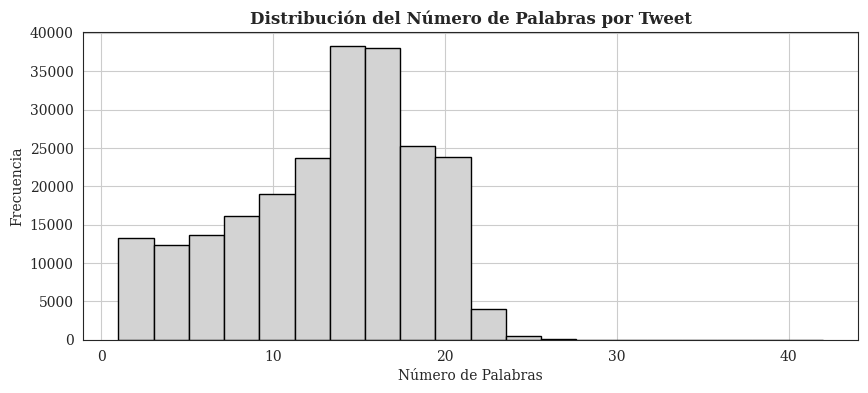

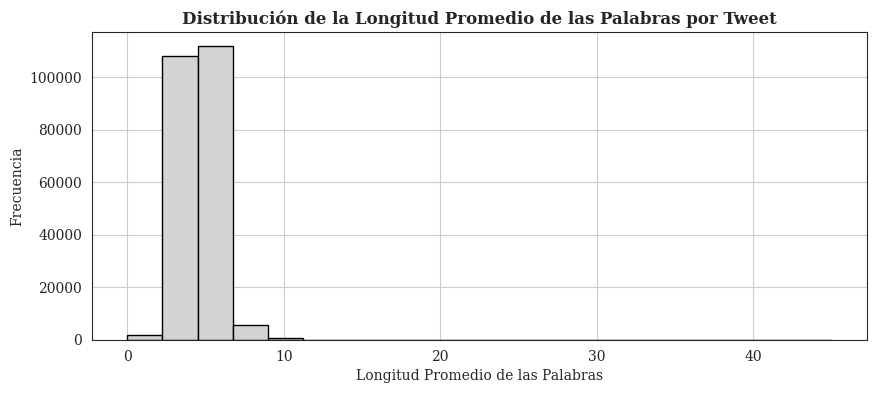

In [10]:
import matplotlib.pyplot as plt

# Graficar el número de palabras en cada tweet
plt.figure(figsize=(10, 4))
plt.hist(df['Number_Of_Words'], bins=20, color='lightgrey', edgecolor='black')
plt.title('Distribución del Número de Palabras por Tweet',fontweight='bold')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Graficar la longitud promedio de las palabras en cada tweet
plt.figure(figsize=(10, 4))
plt.hist(df['Mean_Word_Length'], bins=20, color='lightgrey', edgecolor='black')
plt.title('Distribución de la Longitud Promedio de las Palabras por Tweet',fontweight='bold')
plt.xlabel('Longitud Promedio de las Palabras')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


## Funciones de distribución de los sentimientos

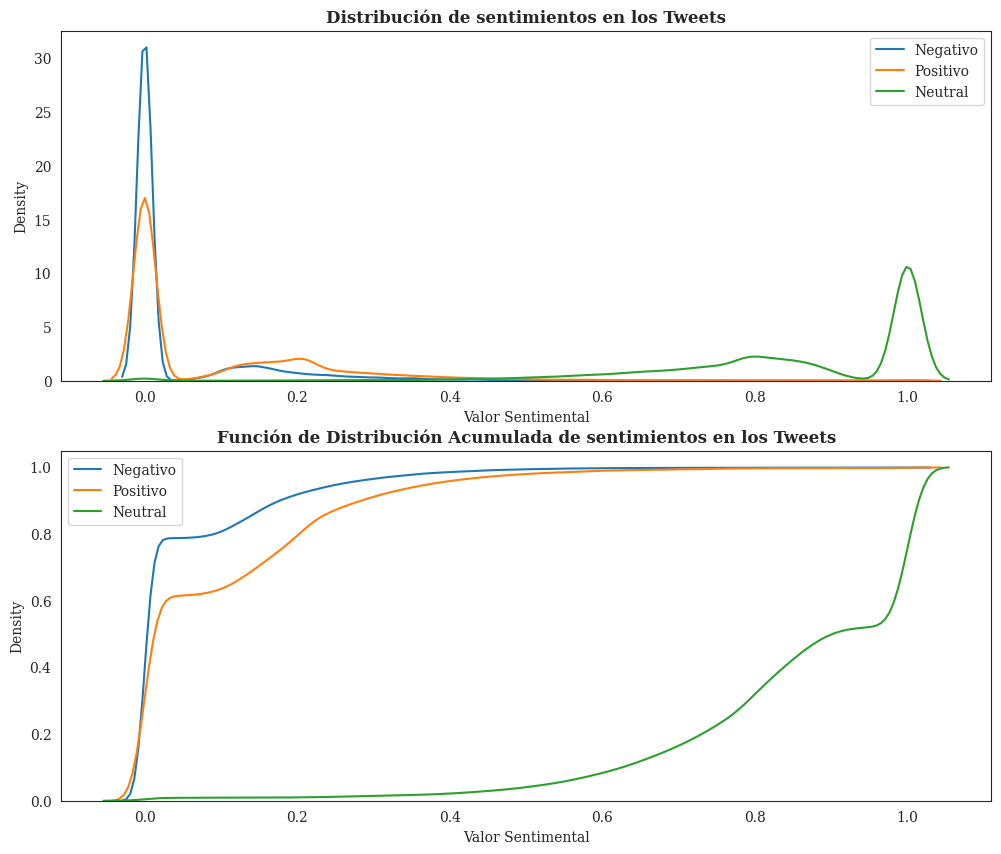

In [11]:
plt.subplot(2, 1, 1)
plt.title('Distribución de sentimientos en los Tweets', fontsize=12, fontweight='bold')
sns.kdeplot(df['Negative Sentiment'], bw_method=0.1, label='Negativo')
sns.kdeplot(df['Positive Sentiment'], bw_method=0.1, label='Positivo')
sns.kdeplot(df['Neutral Sentiment'], bw_method=0.1, label='Neutral')
plt.xlabel('Valor Sentimental')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Función de Distribución Acumulada de sentimientos en los Tweets', fontsize=12, fontweight='bold')
sns.kdeplot(df['Negative Sentiment'], bw_method=0.1, cumulative=True, label='Negativo')
sns.kdeplot(df['Positive Sentiment'], bw_method=0.1, cumulative=True, label='Positivo')
sns.kdeplot(df['Neutral Sentiment'], bw_method=0.1, cumulative=True, label='Neutral')
plt.xlabel('Valor Sentimental')
plt.legend()

plt.show()

In [12]:
df=df.reset_index().drop(columns=['index'])
partitions = []
partitions.append(df.loc[44:np.round(len(df)/3,0)-1,:])
partitions.append(df.loc[np.round(len(df)/3,0):2*int(len(df)/3)-1,:])
partitions.append(df.loc[2*np.round(len(df)/3,0):3*int(len(df)/3)-1,:])

neg_part_means =[]
neg_part_std   =[]
pos_part_means =[]
pos_part_std   =[]
for part in partitions:
    neg_part_means.append(part['Negative Sentiment'].mean())
    neg_part_std.append(part['Negative Sentiment'].std())
    pos_part_means.append(part['Positive Sentiment'].mean())
    pos_part_std.append(part['Positive Sentiment'].std())

res_df = pd.DataFrame({'Media Sentimiento Positivo':pos_part_means,'Media Sentimiento Negativo':neg_part_means,'STD Sentimiento Positivo':pos_part_std,'STD Sentimiento Negativo':neg_part_std},
                     index = [f'Partición_{i}' for i in range(1,4)])


def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partición_1_Mean'] == temp['Partición_2_Mean'])
    m2 = (temp['Partición_1_SD'] == temp['Partición_2_SD'])
    m3 = (temp['Partición_1_Mean'] < temp['Partición_2_Mean']+3) & (temp['Partición_1_Mean'] > temp['Partición_2_Mean']-3)
    m4 = (temp['Partición_1_SD'] < temp['Partición_2_SD']+3) & (temp['Partición_1_SD'] > temp['Partición_2_SD']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partición_1_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partición_1_Mean'])
    df1['Partición_2_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partición_2_Mean'])
    df1['Partición_1_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partición_1_Mean'])
    df1['Partición_2_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partición_2_Mean'])
    df1['Partición_1_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partición_1_Mean'])
    df1['Partición_2_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partición_2_Mean'])

    df1['Partición_1_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partición_1_SD'])
    df1['Partición_2_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partición_2_SD'])
    df1['Partición_1_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partición_1_SD'])
    df1['Partición_2_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partición_2_SD'])
    df1['Partición_1_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partición_1_SD'])
    df1['Partición_2_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partición_2_SD'])

    return df1

#res_df.style.apply(highlight_greater,axis=None)
res_df = res_df.T
res_df = pd.DataFrame(res_df.values, columns=res_df.columns, index=['Positive Sentiment', 'Negative Sentiment', 'Positive Sentiment', 'Negative Sentiment'])
res_df = pd.concat([res_df.iloc[:2, :], res_df.iloc[2:, :]], axis=1)
res_df.columns = ['Partición_1_Mean', 'Partición_2_Mean', 'Partición_3_Mean', 'Partición_1_SD', 'Partición_2_SD', 'Partición_3_SD']

# Aquí aplicamos la función highlight_greater al DataFrame estilo de Pandas
res_df.style.apply(highlight_greater, axis=None)


,Partición_1_Mean,Partición_2_Mean,Partición_3_Mean,Partición_1_SD,Partición_2_SD,Partición_3_SD
Positive Sentiment,0.098507,0.073595,0.106171,0.148696,0.130879,0.150362
Negative Sentiment,0.052046,0.035197,0.042489,0.106342,0.088393,0.098537


In [13]:
#Sorting And Feature Engineering
df = df.sort_values(by='date')
ft_data=df.copy()

ft_data['date'] = pd.to_datetime(df['date']).dt.date

ft_data['year']         = pd.DatetimeIndex(ft_data['date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1

## Evolución mensual de los sentimientos

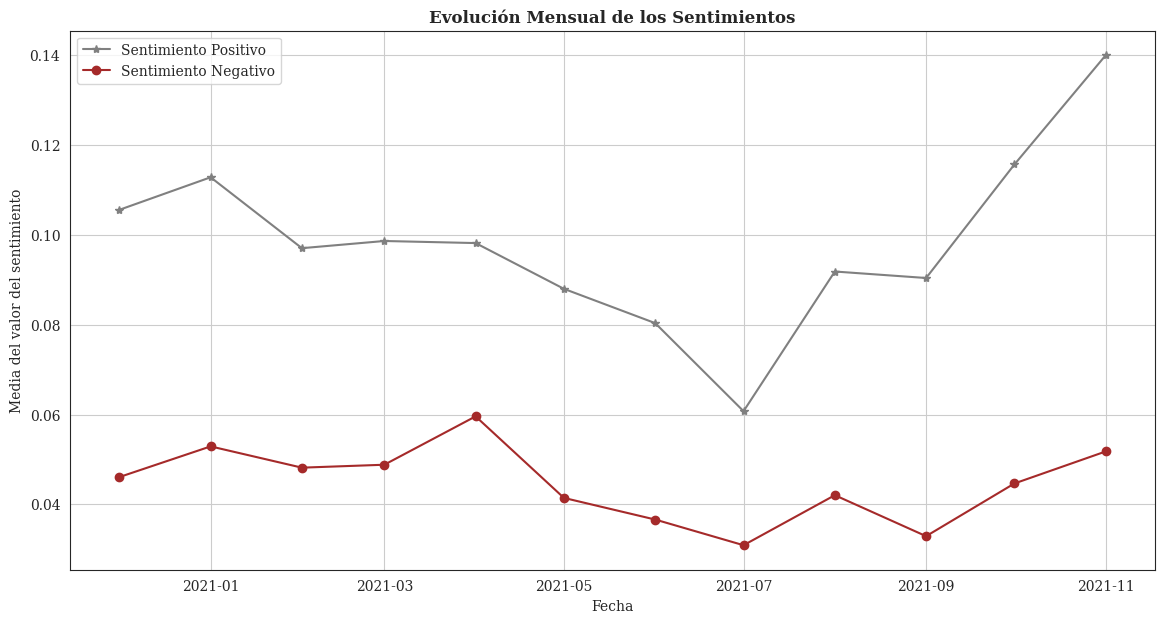

In [14]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

monthly_sentiments = df.groupby(df['date'].dt.to_period('M')).agg({
    'Positive Sentiment': 'mean',
    'Negative Sentiment': 'mean',
    'Neutral Sentiment': 'mean'
}).reset_index()

monthly_sentiments['date'] = monthly_sentiments['date'].dt.to_timestamp()

plt.figure(figsize=(14, 7))
plt.plot(monthly_sentiments['date'], monthly_sentiments['Positive Sentiment'], marker='*', label='Sentimiento Positivo',color='gray')
plt.plot(monthly_sentiments['date'], monthly_sentiments['Negative Sentiment'], marker='o', label='Sentimiento Negativo',color='brown')
#plt.plot(monthly_sentiments['date'], monthly_sentiments['Neutral Sentiment'], marker='*', label='Sentimiento Neutral')
plt.title('Evolución Mensual de los Sentimientos', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Media del valor del sentimiento')
plt.legend()
plt.grid(True)
plt.show()

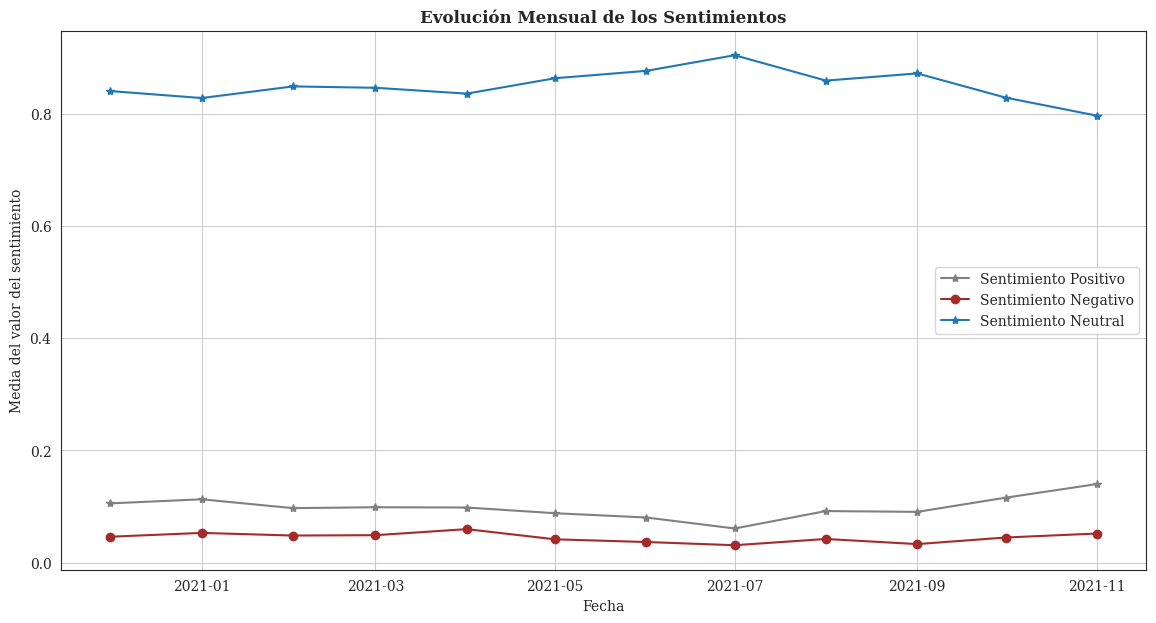

In [15]:
monthly_sentiments = df.groupby(df['date'].dt.to_period('M')).agg({
    'Positive Sentiment': 'mean',
    'Negative Sentiment': 'mean',
    'Neutral Sentiment': 'mean'
}).reset_index()

monthly_sentiments['date'] = monthly_sentiments['date'].dt.to_timestamp()

plt.figure(figsize=(14, 7))
plt.plot(monthly_sentiments['date'], monthly_sentiments['Positive Sentiment'], marker='*', label='Sentimiento Positivo',color='gray')
plt.plot(monthly_sentiments['date'], monthly_sentiments['Negative Sentiment'], marker='o', label='Sentimiento Negativo',color='brown')
plt.plot(monthly_sentiments['date'], monthly_sentiments['Neutral Sentiment'], marker='*', label='Sentimiento Neutral')
plt.title('Evolución Mensual de los Sentimientos', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Media del valor del sentimiento')
plt.legend()
plt.grid(True)
plt.show()

## Matriz de correlación de los sentimientos

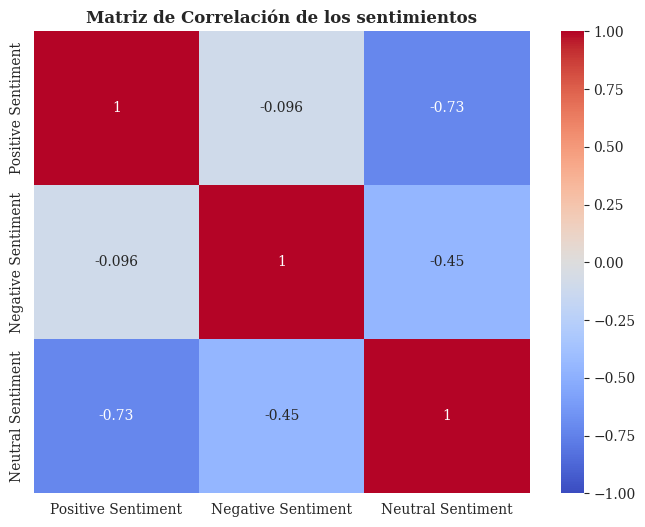

In [16]:
correlation_matrix = df[['Positive Sentiment', 'Negative Sentiment', 'Neutral Sentiment']].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación de los sentimientos', fontsize=12, fontweight='bold')
plt.show()

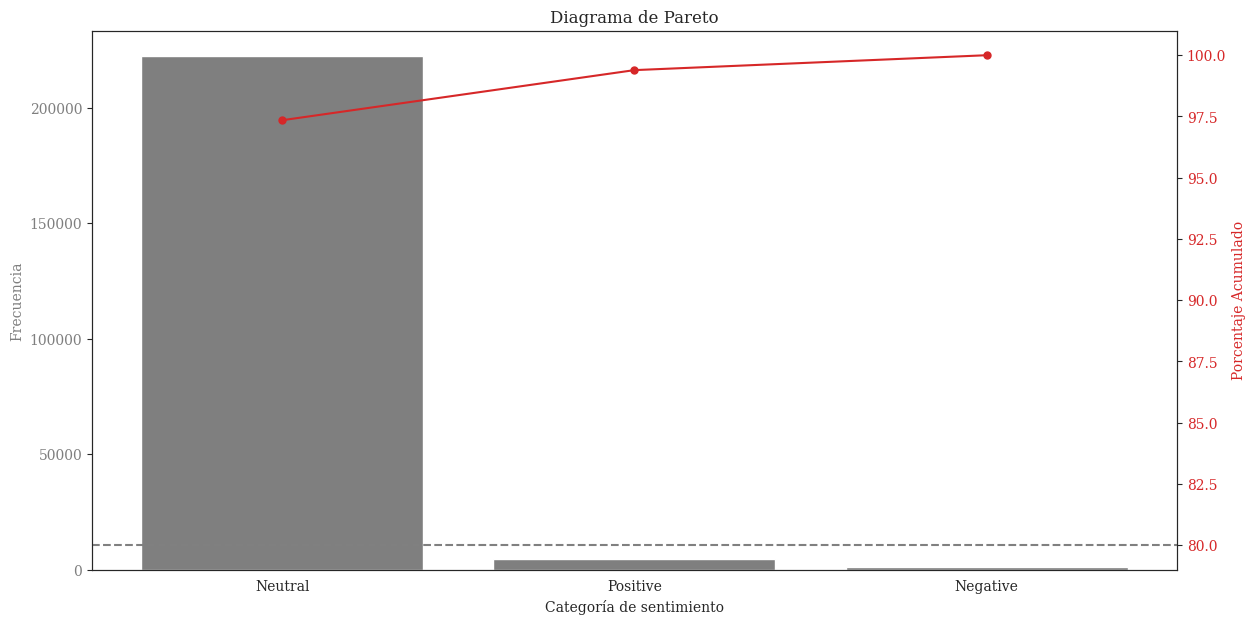

In [17]:
# Clasificar los tweets en categorías de sentimientos
df['Sentiment Category'] = df.apply(
    lambda row: 'Positive' if row['Positive Sentiment'] > max(row['Negative Sentiment'], row['Neutral Sentiment']) else (
        'Negative' if row['Negative Sentiment'] > max(row['Positive Sentiment'], row['Neutral Sentiment']) else 'Neutral'
    ), axis=1
)

# Contar la frecuencia de cada categoría de sentimiento
sentiment_counts = df['Sentiment Category'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Frequency']

# Calcular el porcentaje acumulado
sentiment_counts['Cumulative Percentage'] = sentiment_counts['Frequency'].cumsum() / sentiment_counts['Frequency'].sum() * 100

# Gráfico de Pareto
fig, ax1 = plt.subplots(figsize=(14, 7))

# Gráfico de barras para las frecuencias
ax1.bar(sentiment_counts['Sentiment'], sentiment_counts['Frequency'], color='C7')
ax1.set_xlabel('Categoría de sentimiento')
ax1.set_ylabel('Frecuencia', color='C7')
ax1.tick_params(axis='y', labelcolor='C7')

# Gráfico de líneas para el porcentaje acumulado
ax2 = ax1.twinx()
ax2.plot(sentiment_counts['Sentiment'], sentiment_counts['Cumulative Percentage'], color='C3', marker='o', ms=5)
ax2.set_ylabel('Porcentaje Acumulado', color='C3')
ax2.tick_params(axis='y', labelcolor='C3')
ax2.axhline(80, color='grey', linestyle='--')

plt.title('Diagrama de Pareto')
plt.show()

# Análisis de series temporales

<ipython-input-19-668fce0ef15a>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




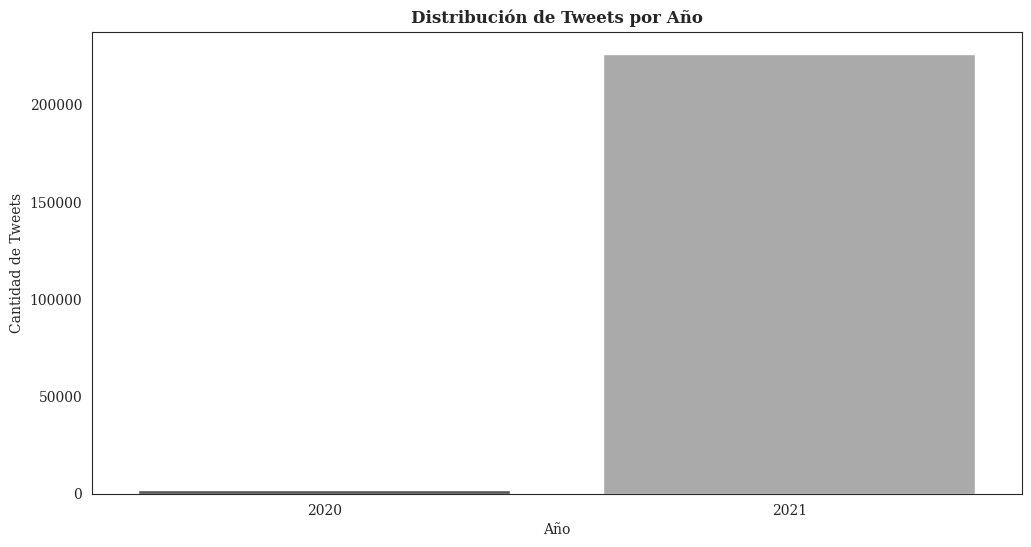

<ipython-input-19-668fce0ef15a>:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




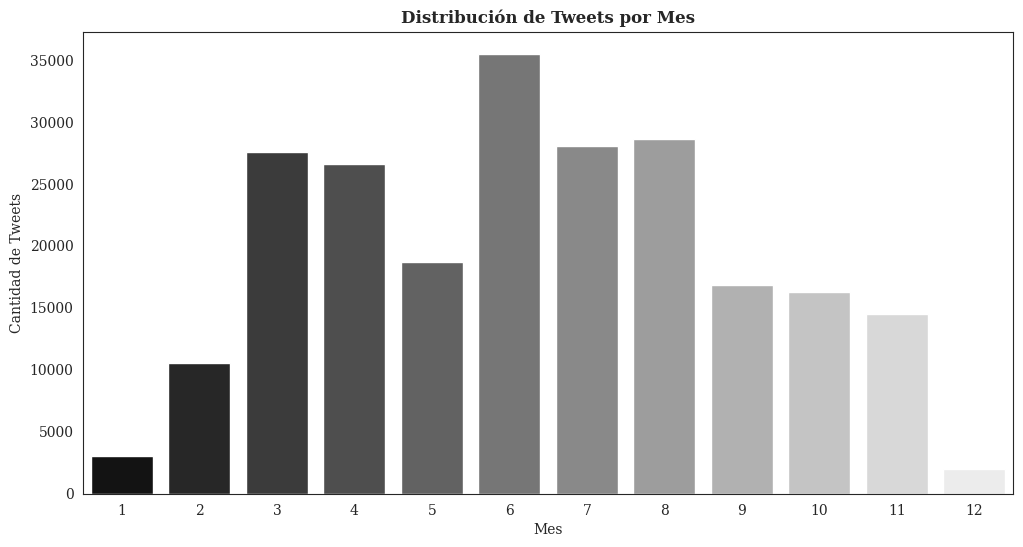

<ipython-input-19-668fce0ef15a>:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




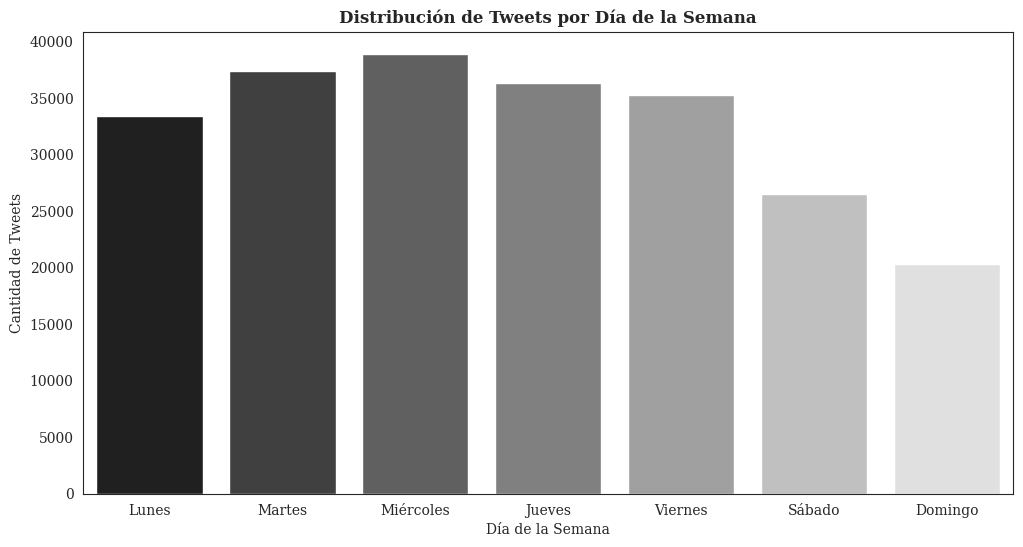

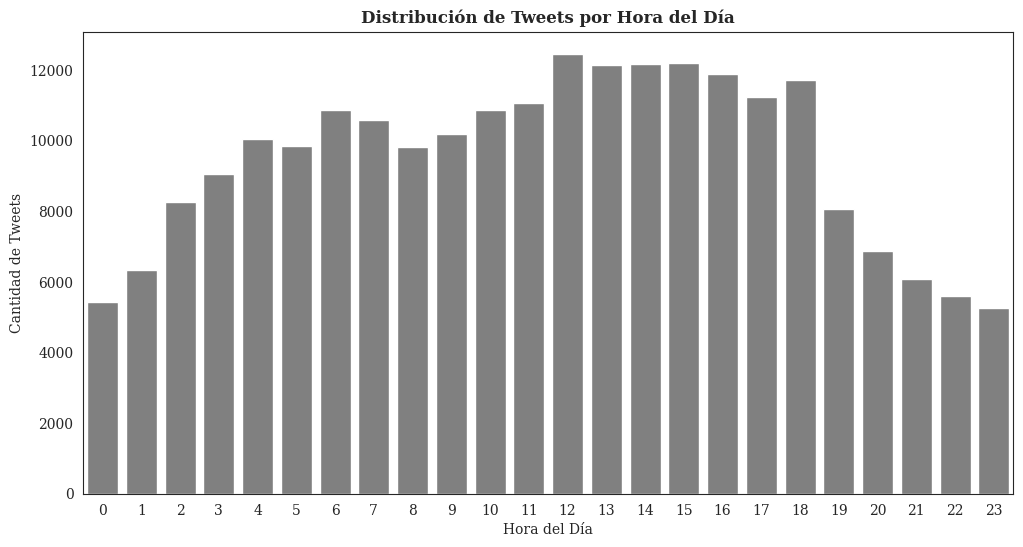

<ipython-input-19-668fce0ef15a>:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




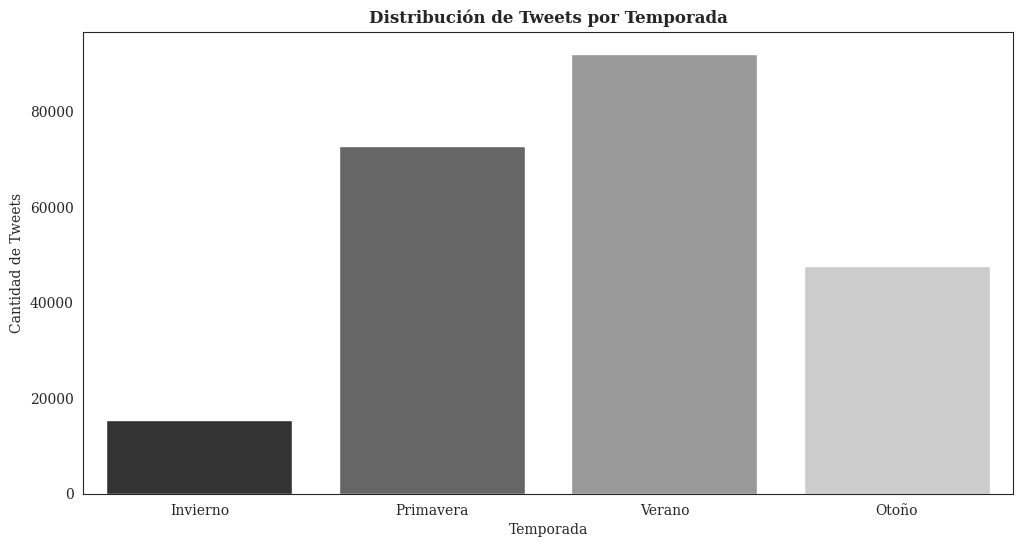

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir la columna 'date' a tipo datetime y extraer características temporales adicionales
ft_data['date'] = pd.to_datetime(df['date'])

ft_data['weekday'] = ft_data['date'].dt.weekday
ft_data['is_weekend'] = ft_data['weekday'] >= 5
ft_data['hour'] = ft_data['date'].dt.hour
ft_data['minute'] = ft_data['date'].dt.minute
ft_data['second'] = ft_data['date'].dt.second

# Crear etiquetas de temporada
season_labels = {1: 'Invierno', 2: 'Primavera', 3: 'Verano', 4: 'Otoño'}
ft_data['season_label'] = ft_data['season'].map(season_labels)

# Mostrar una muestra del DataFrame con las nuevas características
ft_data.head()

# Visualizaciones para explorar las nuevas características

# Distribución de tweets por año
plt.figure(figsize=(12, 6))
sns.countplot(x='year', data=ft_data, palette='lightgray')
plt.title('Distribución de Tweets por Año',fontsize=12,fontweight='bold')
plt.xlabel('Año')
plt.ylabel('Cantidad de Tweets')
plt.show()

# Distribución de tweets por mes
plt.figure(figsize=(12, 6))
sns.countplot(x='month', data=ft_data,palette='gray')
plt.title('Distribución de Tweets por Mes',fontsize=12,fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Tweets')
plt.show()

# Distribución de tweets por día de la semana
plt.figure(figsize=(12, 6))
sns.countplot(x='weekday', data=ft_data, palette='gray')
plt.title('Distribución de Tweets por Día de la Semana',fontsize=12,fontweight='bold')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de Tweets')
plt.xticks(ticks=range(7), labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.show()

# Distribución de tweets por hora del día
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=ft_data, color='gray')
plt.title('Distribución de Tweets por Hora del Día',fontsize=12,fontweight='bold')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Tweets')
plt.show()

# Distribución de tweets por temporada
plt.figure(figsize=(12, 6))
sns.countplot(x='season_label', data=ft_data, palette='gray')
plt.title('Distribución de Tweets por Temporada',fontsize=12,fontweight='bold')
plt.xlabel('Temporada')
plt.ylabel('Cantidad de Tweets')
plt.show()

In [ ]:
df['date'] = pd.to_datetime(df['date'])

# Crear una serie temporal contando tweets por día
tweets_daily = df.set_index('date').resample('D').size()

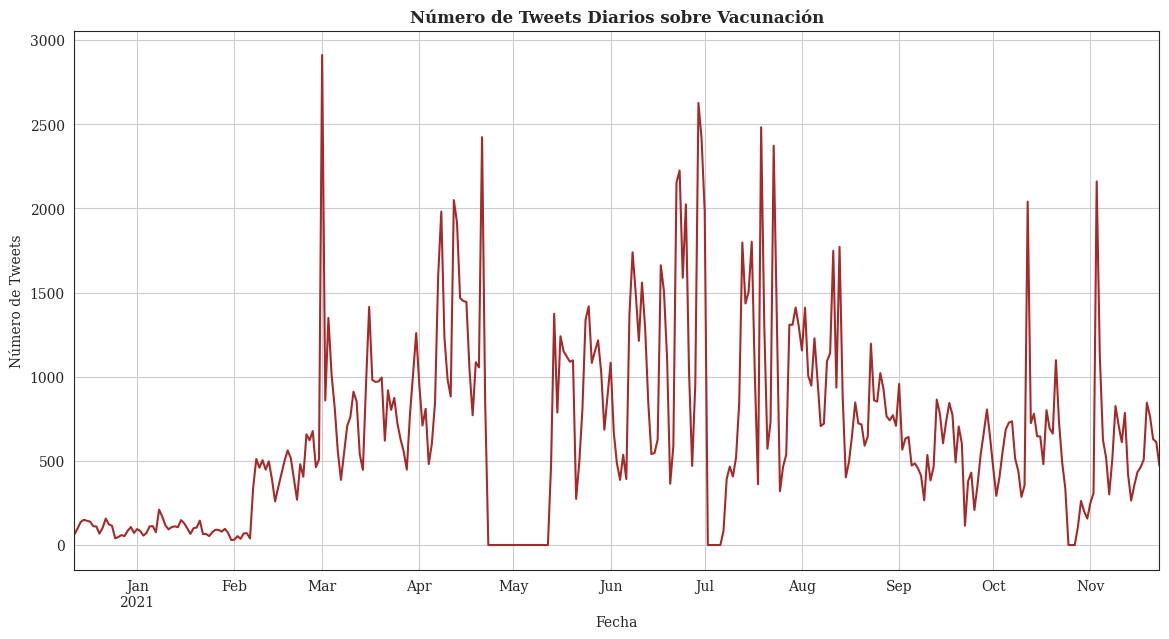

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
tweets_daily.plot(color='brown')
plt.title('Número de Tweets Diarios sobre Vacunación', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Número de Tweets')
plt.grid(True)
plt.show()

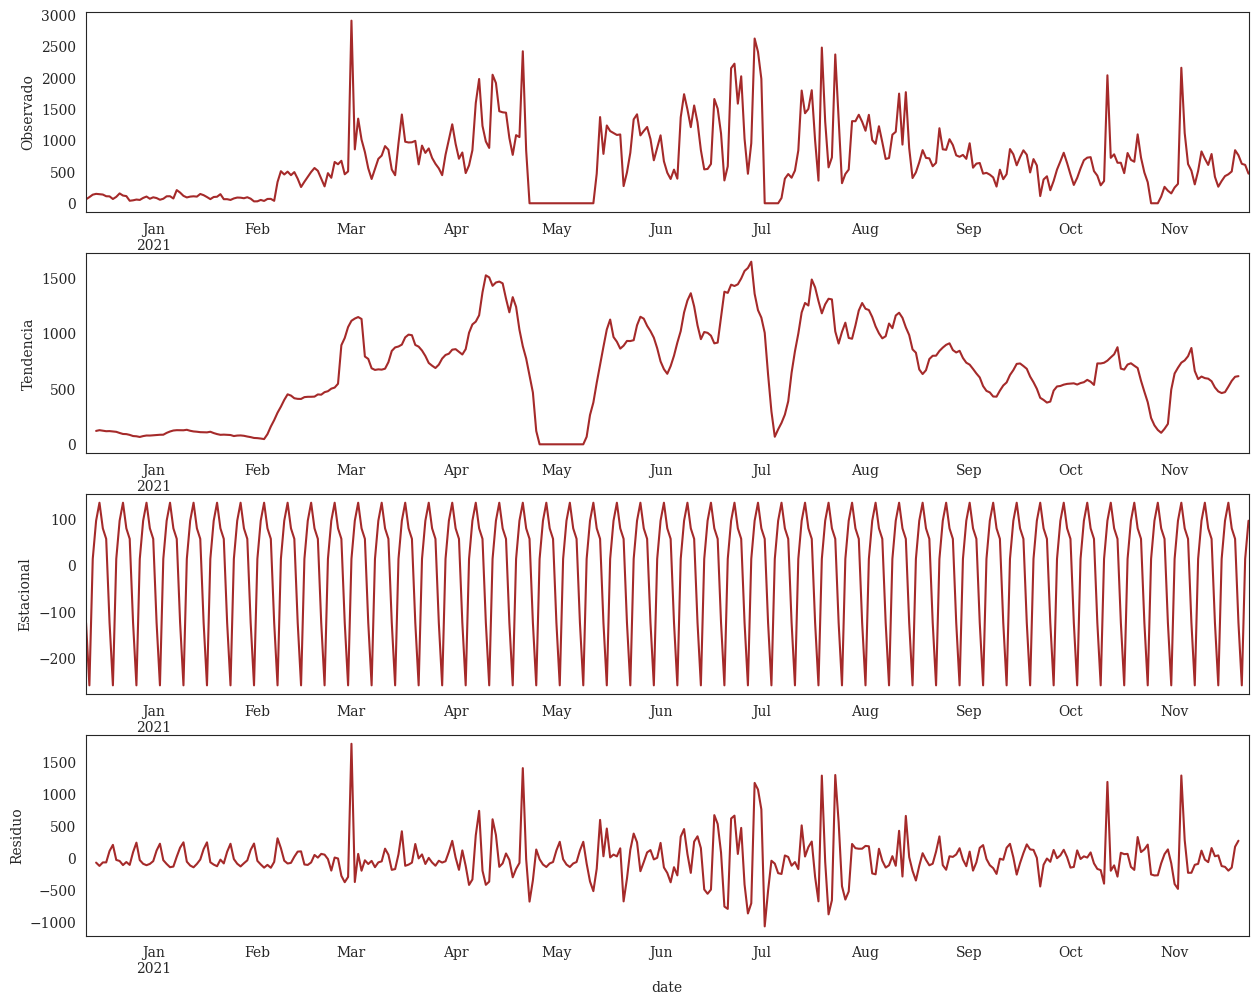

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie temporal
decomposition = seasonal_decompose(tweets_daily, model='additive')

# Visualización de los componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=ax1, legend=False, color='brown')
ax1.set_ylabel('Observado')

decomposition.trend.plot(ax=ax2, legend=False, color='brown')
ax2.set_ylabel('Tendencia')

decomposition.seasonal.plot(ax=ax3, legend=False, color='brown')
ax3.set_ylabel('Estacional')

decomposition.resid.plot(ax=ax4, legend=False, color='brown')
ax4.set_ylabel('Residuo')

plt.show()

## Histograma y densidad de los componentes

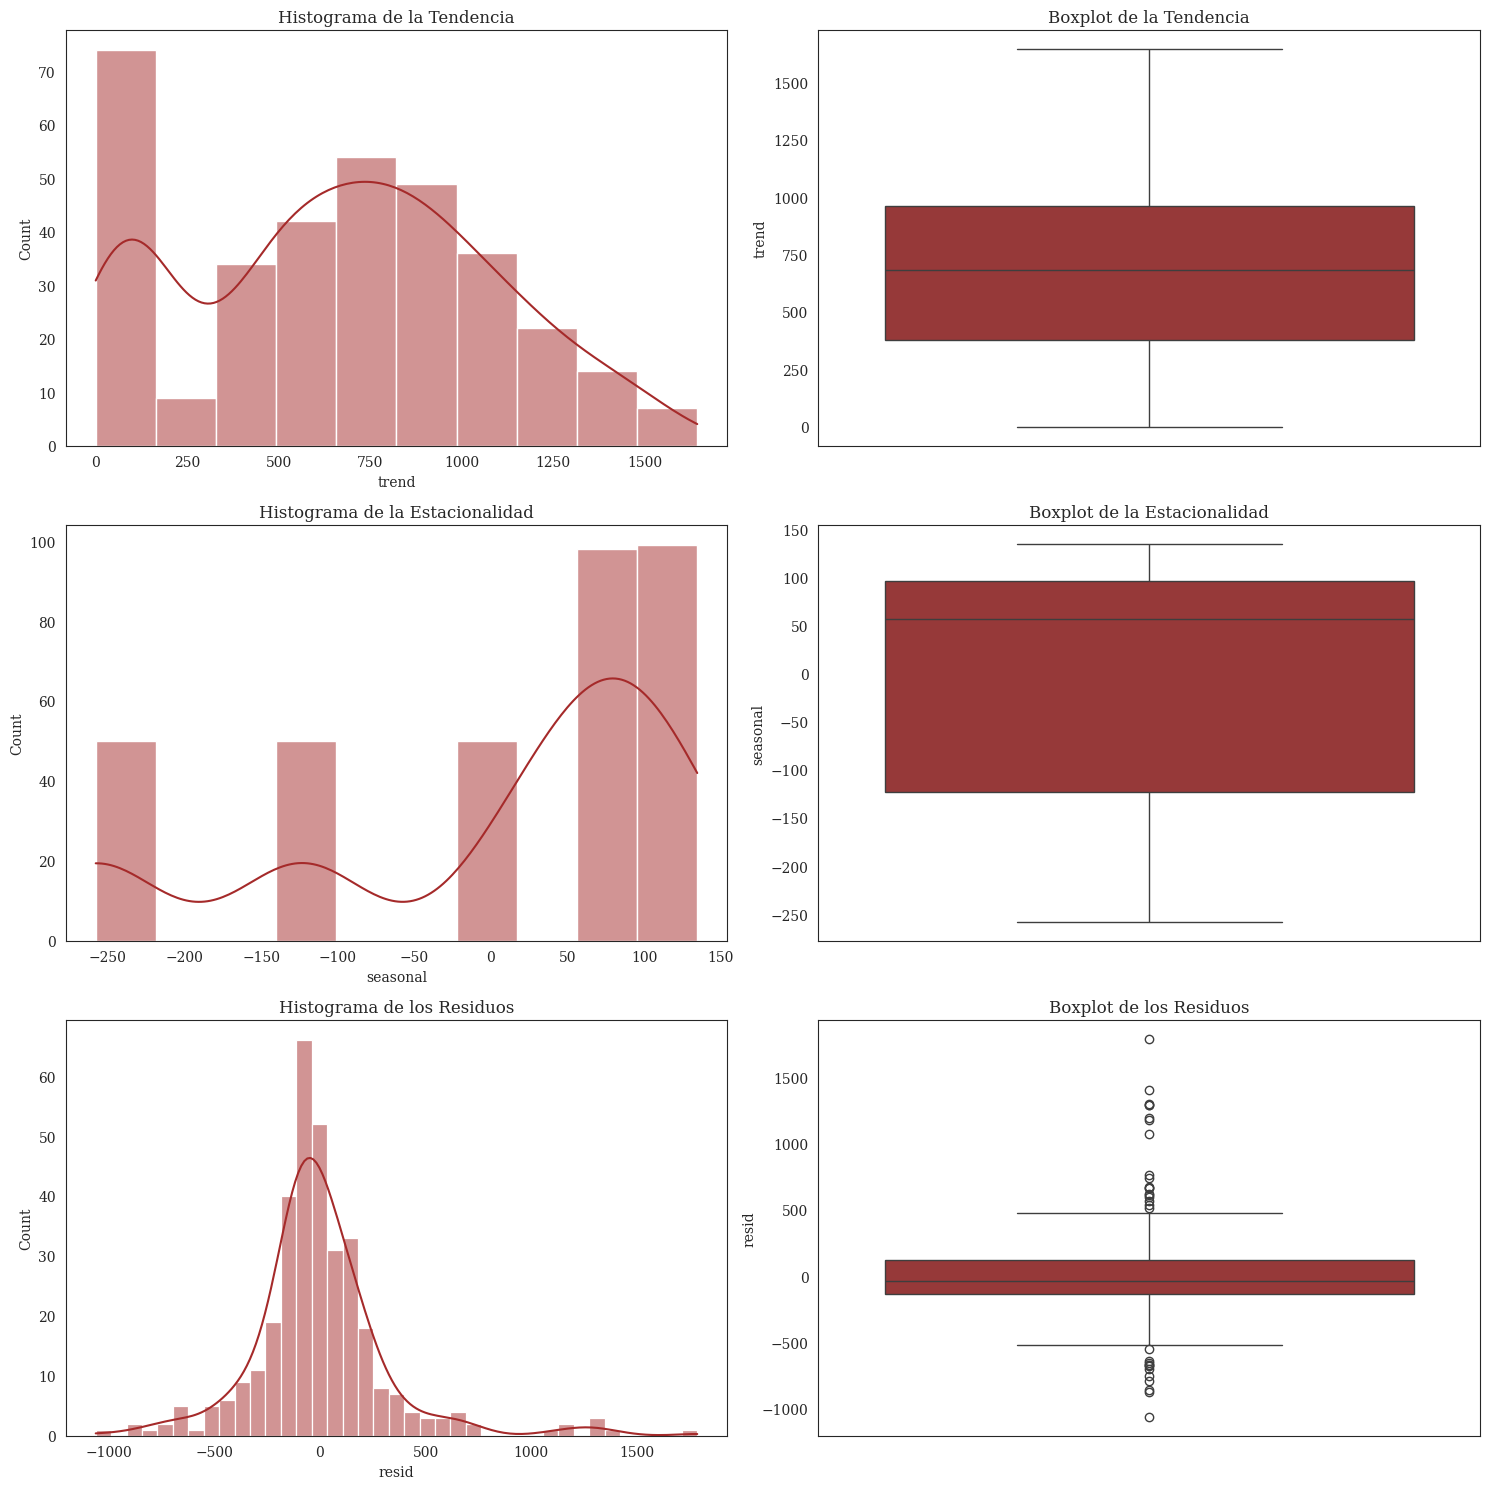

In [ ]:
import seaborn as sns

# Descomposición de la serie temporal
decomposition = seasonal_decompose(tweets_daily, model='additive')

# Componentes de la descomposición
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
residual = decomposition.resid.dropna()

# Plot histograms and density plots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Trend component
sns.histplot(trend, kde=True, ax=axes[0, 0], color='brown')
axes[0, 0].set_title('Histograma de la Tendencia')
sns.boxplot(trend, ax=axes[0, 1], color='brown')
axes[0, 1].set_title('Boxplot de la Tendencia')

# Seasonal component
sns.histplot(seasonal, kde=True, ax=axes[1, 0], color='brown')
axes[1, 0].set_title('Histograma de la Estacionalidad')
sns.boxplot(seasonal, ax=axes[1, 1], color='brown')
axes[1, 1].set_title('Boxplot de la Estacionalidad')

# Residual component
sns.histplot(residual, kde=True, ax=axes[2, 0], color='brown')
axes[2, 0].set_title('Histograma de los Residuos')
sns.boxplot(residual, ax=axes[2, 1], color='brown')
axes[2, 1].set_title('Boxplot de los Residuos')

plt.tight_layout()
plt.show()


## ACF y PACF

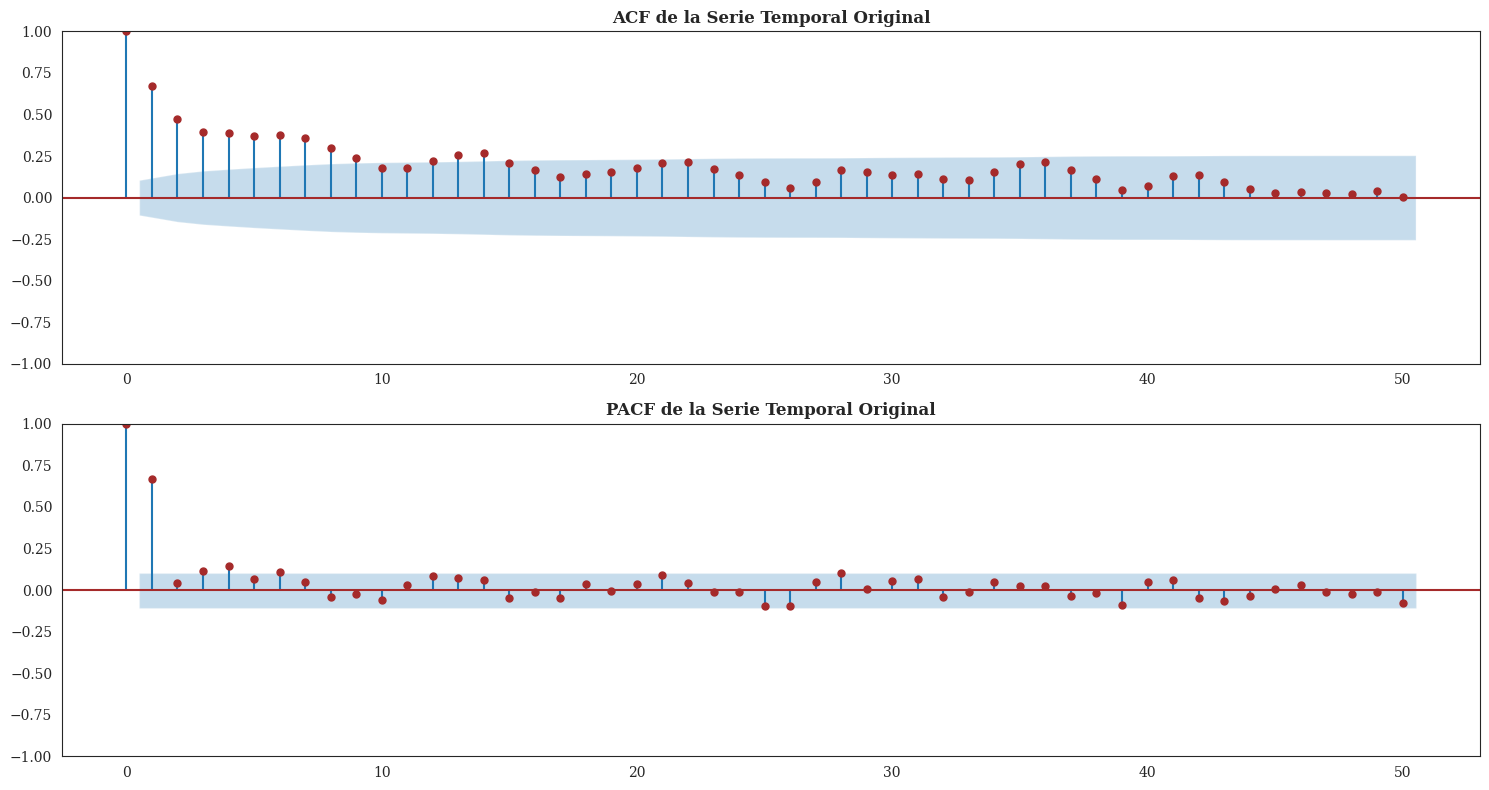

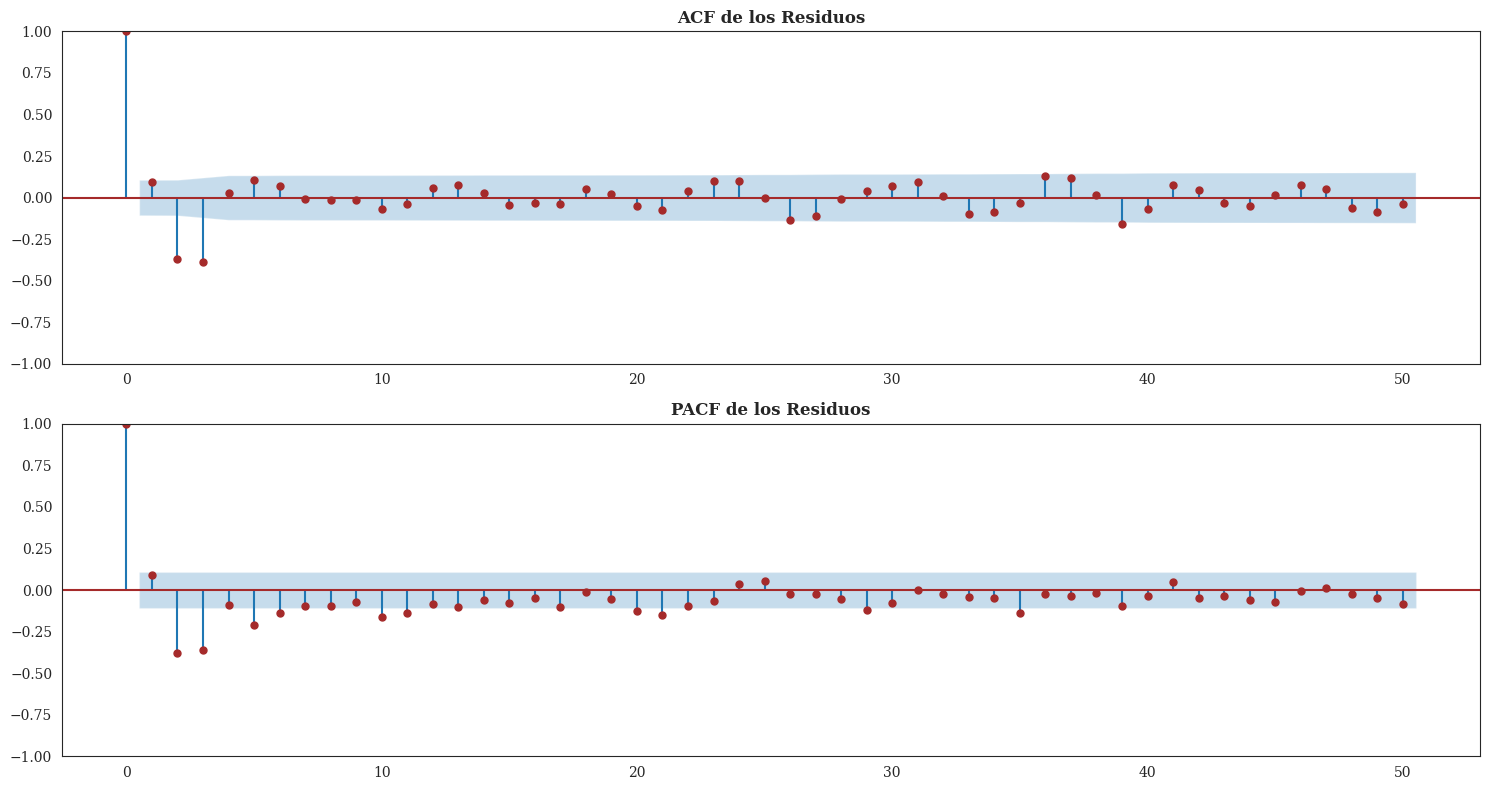

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the original series
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(tweets_daily.dropna(), ax=axes[0], lags=50, color='brown')
axes[0].set_title('ACF de la Serie Temporal Original', fontsize=12, fontweight='bold')
plot_pacf(tweets_daily.dropna(), ax=axes[1], lags=50, color='brown')
axes[1].set_title('PACF de la Serie Temporal Original', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot ACF and PACF for the residuals
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(residual, ax=axes[0], lags=50, color='brown')
axes[0].set_title('ACF de los Residuos', fontsize=12, fontweight='bold')
plot_pacf(residual, ax=axes[1], lags=50, color='brown')
axes[1].set_title('PACF de los Residuos', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Test de Normalidad

In [ ]:
from scipy.stats import shapiro, kstest

# Shapiro-Wilk test
shapiro_test = shapiro(residual)
print("Shapiro-Wilk test:", shapiro_test)

# Kolmogorov-Smirnov test
kstest_test = kstest(residual, 'norm')
print("Kolmogorov-Smirnov test:", kstest_test)

Shapiro-Wilk test: ShapiroResult(statistic=0.8708869218826294, pvalue=2.8239985817229767e-16)
Kolmogorov-Smirnov test: KstestResult(statistic=0.5689146061956153, pvalue=7.531165409535547e-105, statistic_location=-4.961465708732469, statistic_sign=1)


In [ ]:
from scipy.stats import shapiro, kstest

# Shapiro-Wilk test
shapiro_test = shapiro(residual)
shapiro_test_result = ("Shapiro-Wilk test:", shapiro_test)

# Kolmogorov-Smirnov test
kstest_test = kstest(residual, 'norm')
kstest_test_result = ("Kolmogorov-Smirnov test:", kstest_test)

shapiro_test_result, kstest_test_result


(('Shapiro-Wilk test:',
  ShapiroResult(statistic=0.8708869218826294, pvalue=2.8239985817229767e-16)),
 ('Kolmogorov-Smirnov test:',
  KstestResult(statistic=0.5689146061956153, pvalue=7.531165409535547e-105, statistic_location=-4.961465708732469, statistic_sign=1)))

## Otros gráficos

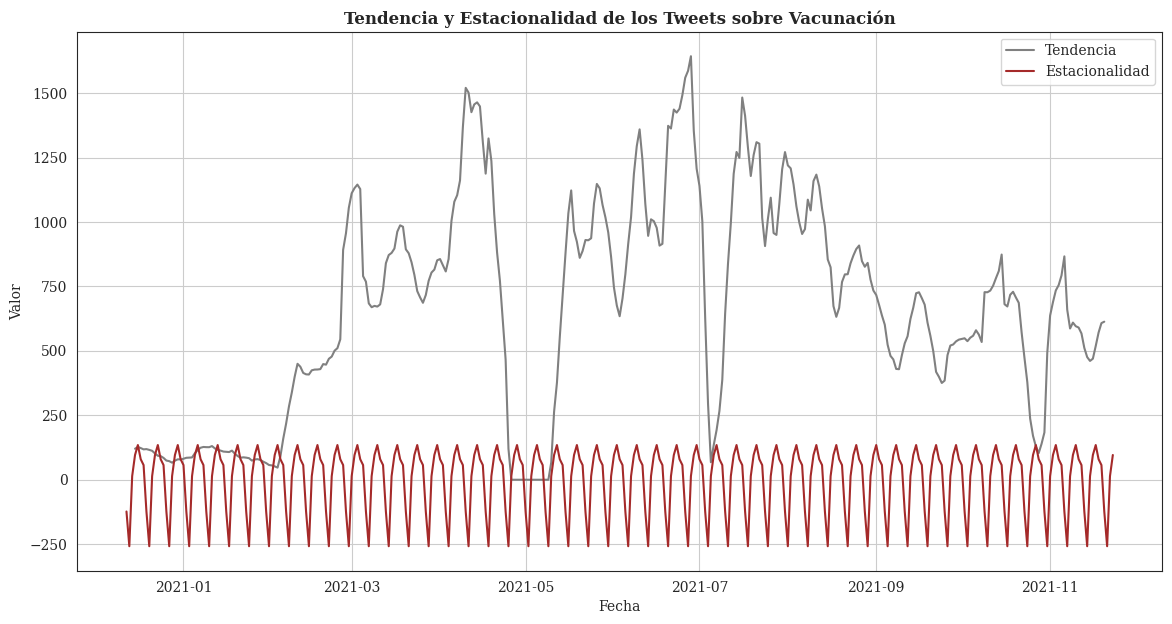

In [ ]:
# Gráfico de tendencia y estacionalidad superpuestos
plt.figure(figsize=(14, 7))
plt.plot(trend, label='Tendencia',color='gray')
plt.plot(seasonal, label='Estacionalidad',color='brown')
plt.title('Tendencia y Estacionalidad de los Tweets sobre Vacunación', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# Análisis geoespacial

In [ ]:
# Buscamos si de los 66909 usuarios sin localización, tienen otros tweets con alguna localización
users_with_nan_location = df[df['user_location'].isnull()]['user_name']

tweets_with_location = df[df['user_name'].isin(users_with_nan_location) & ~df['user_location'].isnull()]

print("Usuarios con NaN en 'user_location' que tienen otros tweets con ubicación:")
print(tweets_with_location[['user_name', 'user_location']])

Usuarios con NaN en 'user_location' que tienen otros tweets con ubicación:
            user_name               user_location
5                 Dee         Birmingham, England
295     World Affairs           San Francisco, CA
105             Katie                    Kentucky
583               Ali  Wiltshire & Shrewsbury too
505            Miguel                          UK
...               ...                         ...
223592            jay                          Uk
225337         Sanjay      ÜT: 18.45833,73.920092
225325       aegean88              Global Citizen
225324       aegean88              Global Citizen
225307       aegean88              Global Citizen

[23403 rows x 2 columns]


In [ ]:
#buscamos un usuario en concreto para saber la localización de sus tweets
from tabulate import tabulate
tweets_usuario = df[df['user_name'] == 'Ali']
ubicaciones_unicas = tweets_usuario['user_location'].unique()

print(f"Ubicaciones únicas para el usuario:")
print(tabulate(ubicaciones_unicas.reshape(-1, 1)))

Ubicaciones únicas para el usuario:
--------------------------
Wiltshire & Shrewsbury too
Karachi, Pakistan
Blacksburg, VA
پاکستان
Dıj güjjler
nan
Bulawayo
Ghost River Triangle
--------------------------


In [ ]:
# Sustituir el Nan por la ubicación más utilizada.

user_loc = {}

for user_name, group in df.groupby('user_name'):
    loc_frecuentes = group['user_location'].mode()
    if not loc_frecuentes.empty:
        ubicacion_mas_frecuente = loc_frecuentes.iloc[0]
        user_loc[user_name] = ubicacion_mas_frecuente

for index, row in df.iterrows():
    user_location = row['user_location']

    if pd.isnull(user_location):
        ubicacion_mas_frecuente = user_loc.get(row['user_name'], None)
        if ubicacion_mas_frecuente:
            df.at[index, 'user_location'] = ubicacion_mas_frecuente

In [ ]:
tweets_usuario = df[df['user_name'] == 'Ali']

ubicaciones_unicas = tweets_usuario['user_location'].unique()

print(f"Ubicaciones únicas para el usuario:")
for ubicacion in ubicaciones_unicas:
    print(ubicacion)

Ubicaciones únicas para el usuario:
Wiltshire & Shrewsbury too
Karachi, Pakistan
Blacksburg, VA
پاکستان
Dıj güjjler
Bulawayo
Ghost River Triangle


In [ ]:
# Importamos un dataset de referencia con las ciudades y paises del mundo
df_cities = pd.read_csv("worldcities.csv")

In [ ]:
! pip install geotext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from geotext import GeoText

df['user_location'] = df['user_location'].apply(lambda x: x.title() if isinstance(x, str) else 'Unknown')
df['country_location'] = df['user_location'].apply(lambda x: GeoText(str(x)).countries[0] if len(GeoText(str(x)).countries) != 0 else np.nan)
df['city_location'] = df['user_location'].apply(lambda x: GeoText(str(x)).cities[0] if len(GeoText(str(x)).cities) != 0 else np.nan)

In [ ]:
df = df[~((df['country_location'] == 'Unknown') & (df['city_location'] == 'Unknown'))]

In [ ]:
country_data = pd.read_csv('https://gist.githubusercontent.com/cpl/3dc2d19137588d9ae202d67233715478/raw/3d801e76e1ec3e6bf93dd7a87b7f2ce8afb0d5de/countries_codes_and_coordinates.csv')

# Limpieza de las columnas para eliminar comillas dobles y espacios adicionales
country_data['Alpha-2 code'] = country_data['Alpha-2 code'].str.strip().str.replace('"', '')
country_data['Alpha-3 code'] = country_data['Alpha-3 code'].str.strip().str.replace('"', '')
country_data['Country'] = country_data['Country'].str.strip().str.replace('"', '')

# Crear diccionarios para mapear códigos ISO a nombres de países
iso2_to_country = pd.Series(country_data['Country'].values, index=country_data['Alpha-2 code']).to_dict()
iso3_to_country = pd.Series(country_data['Country'].values, index=country_data['Alpha-3 code']).to_dict()

In [ ]:
def find_country_from_iso(location):
    # Asumiendo que location puede ser un código ISO2 o ISO3
    location = str(location).upper()  # Los códigos ISO suelen estar en mayúsculas
    if location in iso2_to_country:
        return iso2_to_country[location]
    elif location in iso3_to_country:
        return iso3_to_country[location]
    else:
        return np.nan  # Si no se encuentra el código, retorna np.nan

# Aplicar la función al DataFrame para crear una nueva columna con el país basado en el código ISO
df['country_from_iso'] = df['user_location'].apply(find_country_from_iso)

In [ ]:
df_cities['city_lower'] = df_cities['city_ascii'].str.lower()

def find_country_by_city(city_name):
    # Verificar primero si city_name es una cadena
    if isinstance(city_name, str):
        # Convertir el nombre de la ciudad a buscar a minúsculas
        city_name = city_name.lower()

        # Buscar en el DataFrame la fila que coincide con el nombre de la ciudad
        match = df_cities[df_cities['city_lower'] == city_name]

        # Si se encuentra una coincidencia, retorna el país correspondiente
        if not match.empty:
            return match['country'].iloc[0]
    # Si city_name no es una cadena o no se encuentra una coincidencia, retorna 'Unknown'
    return 'Unknown'

df['country_from_city'] = df['city_location'].apply(find_country_by_city)

In [ ]:
def combine_location_info(row):
    # Prioriza la ciudad si está disponible y no es NaN
    if pd.notna(row['city_location']) and row['city_location'] != 'Unknown':
        # Aquí necesitas una forma de convertir la ciudad a país, que no está directamente cubierta en tu pregunta.
        # Esto requeriría una base de datos o un servicio adicional que mapee ciudades a países.
        # Por simplicidad, se retorna directamente la ciudad, pero deberías reemplazar esto con el país correspondiente.
        return row['city_location']

    # Si no, usa el país directamente si está disponible y no es NaN
    elif pd.notna(row['country_location']) and row['country_location'] != 'Unknown':
        return row['country_location']

    # Finalmente, utiliza el país derivado de los códigos ISO si está disponible y no es NaN
    elif pd.notna(row['country_from_iso']) and row['country_from_iso'] != 'Unknown':
        return row['country_from_iso']

    # Retorna 'Unknown' si ninguna condición anterior se cumple
    return 'Unknown'

# Aplicar la función para combinar la información en una nueva columna
df['final_country'] = df.apply(combine_location_info, axis=1)

In [ ]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,Neutral Sentiment,Negative Sentiment,Number_Of_Words,Mean_Word_Length,Sentiment Category,country_location,city_location,country_from_iso,country_from_city,final_country
44,1337727767551553536,Daily News Egypt,Egypt,Egypt's Only Daily Independent Newspaper in En...,2009-04-26 07:56:24,278080,116,765,True,2020-12-12 11:55:28,...,0.606001,0.394001,5,6.40,Neutral,Egypt,NaN,NaN,Unknown,Egypt
43,1337728701820268544,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12 11:59:10,...,1.000001,0.000001,15,5.20,Neutral,NaN,London,NaN,United Kingdom,London
42,1337732077278662657,mystic,"Hawaii, Usa",I believe in the goodness of humanity.,2020-05-20 10:57:00,14,162,1341,False,2020-12-12 12:12:35,...,1.000001,0.000001,2,3.50,Neutral,NaN,NaN,NaN,Unknown,Unknown
41,1337732996380696578,KHuntson,Usa🇺🇸,"RN, health educator, writer, researcher, wife,...",2014-01-31 01:25:24,2035,1672,6734,False,2020-12-12 12:16:14,...,1.000001,0.000001,6,5.83,Neutral,NaN,NaN,NaN,Unknown,Unknown
40,1337733048914358272,"Party politics isn't working for anyone, anywhere","Wales, United Kingdom",No lie to another is respectful; no lie to you...,2016-08-03 20:11:00,761,504,33675,False,2020-12-12 12:16:27,...,1.000001,0.000001,10,4.40,Neutral,United Kingdom,NaN,NaN,Unknown,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228207 entries, 44 to 225290
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  228207 non-null  int64         
 1   user_name           228205 non-null  object        
 2   user_location       228207 non-null  object        
 3   user_description    211184 non-null  object        
 4   user_created        228207 non-null  object        
 5   user_followers      228207 non-null  int64         
 6   user_friends        228207 non-null  int64         
 7   user_favourites     228207 non-null  int64         
 8   user_verified       228207 non-null  bool          
 9   date                228207 non-null  datetime64[ns]
 10  text                228207 non-null  object        
 11  hashtags            178504 non-null  object        
 12  source              228088 non-null  object        
 13  retweets            228207 non-nu

In [ ]:
df['final_country'].value_counts()

final_country
Unknown                101785
India                   34506
New Delhi                5517
Toronto                  4415
Mumbai                   3621
                        ...  
Francavilla Fontana         1
Wooster                     1
Ronkonkoma                  1
Stoughton                   1
Subic                       1
Name: count, Length: 3111, dtype: int64

In [ ]:
228207 - 101785

126422

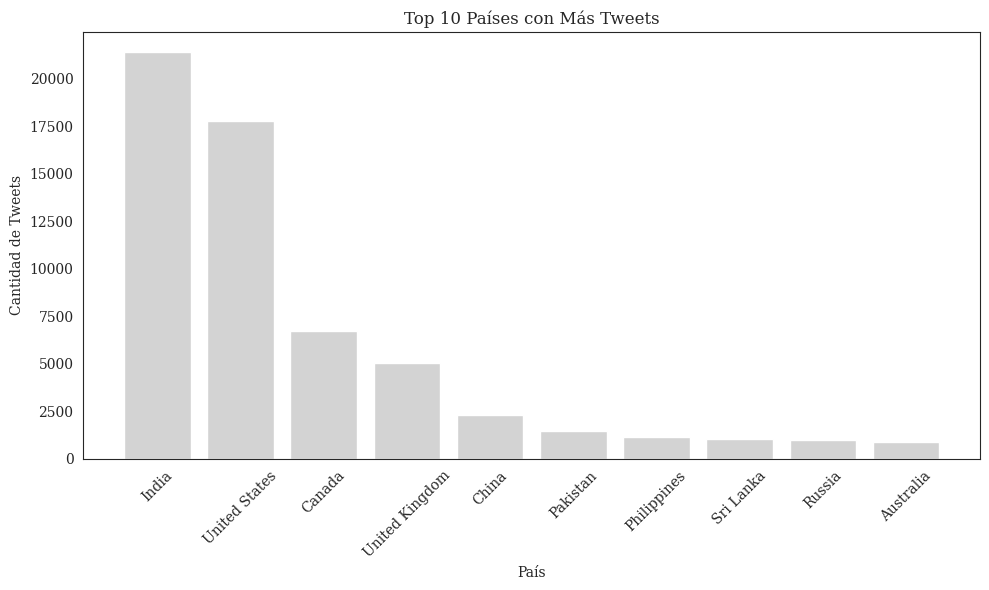

In [ ]:
import matplotlib.pyplot as plt

# Contar los tweets por país
tweets_por_pais = df['country_from_city'].value_counts().reset_index()
tweets_por_pais.columns = ['Pais', 'Cantidad_de_Tweets']

# Obtener los 10 países con más tweets
top_10_paises = tweets_por_pais.iloc[1:11]

plt.figure(figsize=(10, 6))
plt.bar(top_10_paises['Pais'], top_10_paises['Cantidad_de_Tweets'], color='lightgrey')
plt.xlabel('País')
plt.ylabel('Cantidad de Tweets')
plt.title('Top 10 Países con Más Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-43-96962f66d7a1>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



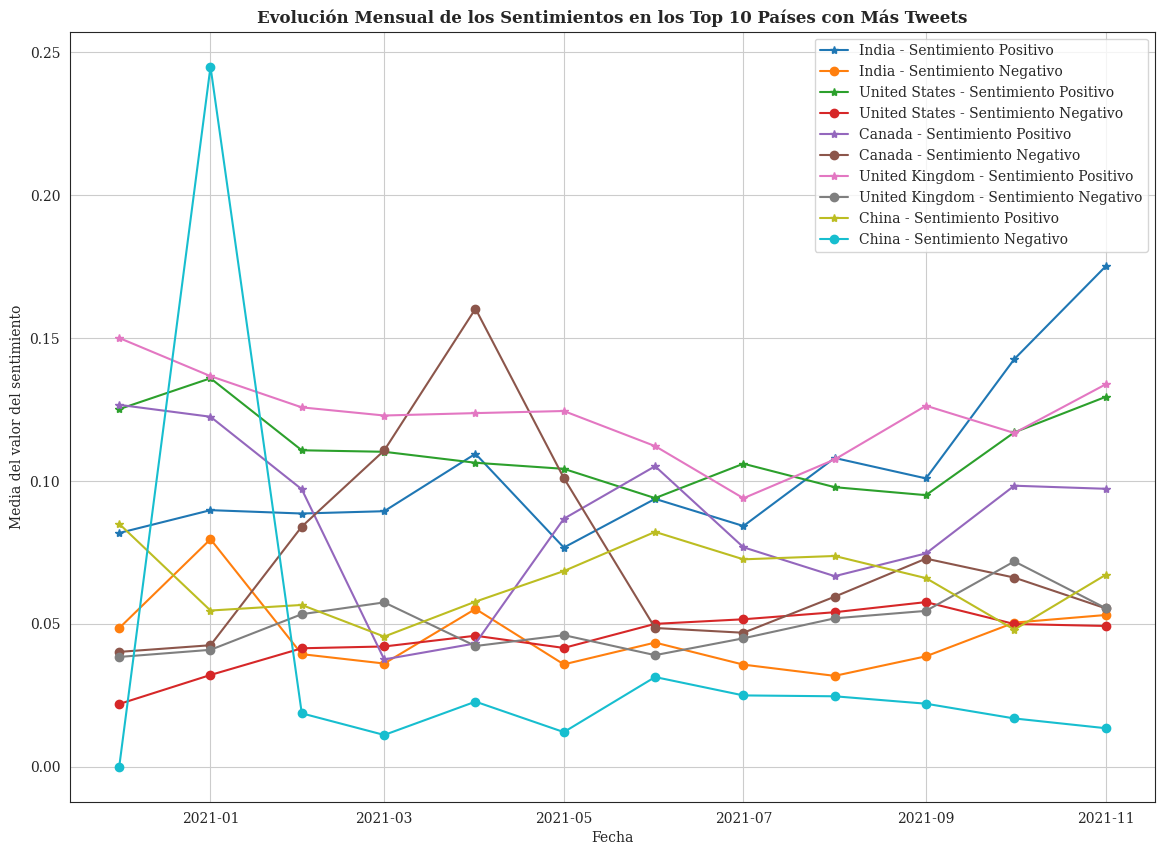

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que ya tenemos las columnas de sentimientos y la columna 'country_from_city' en el DataFrame

# Convertir la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupar por país y mes, calculando los sentimientos medios
monthly_sentiments_country = df.groupby([df['date'].dt.to_period('M'), 'country_from_city']).agg({
    'Positive Sentiment': 'mean',
    'Negative Sentiment': 'mean',
    'Neutral Sentiment': 'mean',
    'id': 'count'  # Contamos la cantidad de tweets
}).reset_index()

# Renombrar la columna de conteo de tweets
monthly_sentiments_country.rename(columns={'id': 'tweet_count'}, inplace=True)

# Obtener los 5 países con más tweets
top_countries = monthly_sentiments_country.groupby('country_from_city')['tweet_count'].sum().nlargest(6).index[1:6]

# Filtrar los datos para estos países
top_countries_sentiments = monthly_sentiments_country[monthly_sentiments_country['country_from_city'].isin(top_countries)]

# Convertir el periodo a timestamp para facilitar la visualización
top_countries_sentiments['date'] = top_countries_sentiments['date'].dt.to_timestamp()

# Visualización
plt.figure(figsize=(14, 10))

for country in top_countries:
    country_data = top_countries_sentiments[top_countries_sentiments['country_from_city'] == country]
    plt.plot(country_data['date'], country_data['Positive Sentiment'], marker='*', label=f'{country} - Sentimiento Positivo')
    plt.plot(country_data['date'], country_data['Negative Sentiment'], marker='o', label=f'{country} - Sentimiento Negativo')

plt.title('Evolución Mensual de los Sentimientos en los Top 10 Países con Más Tweets', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Media del valor del sentimiento')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-44-5e8ee081e247>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



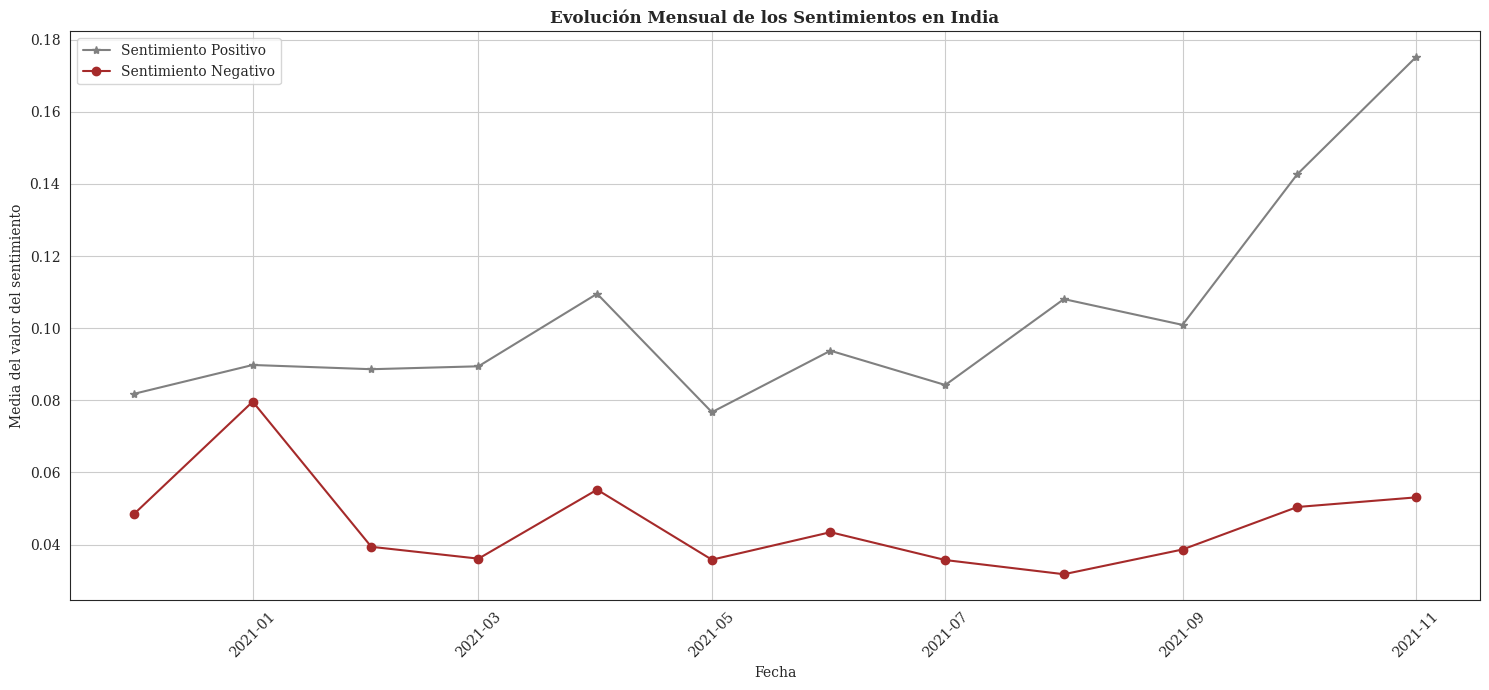

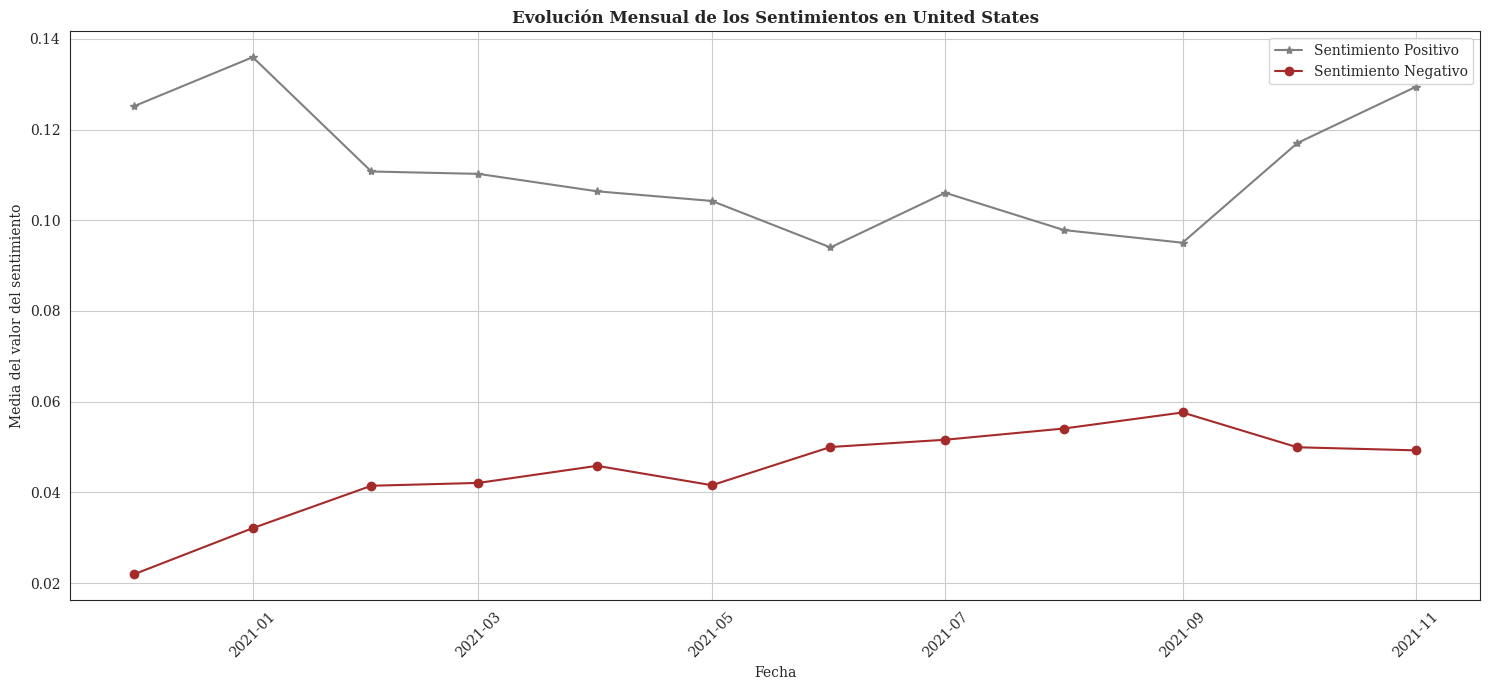

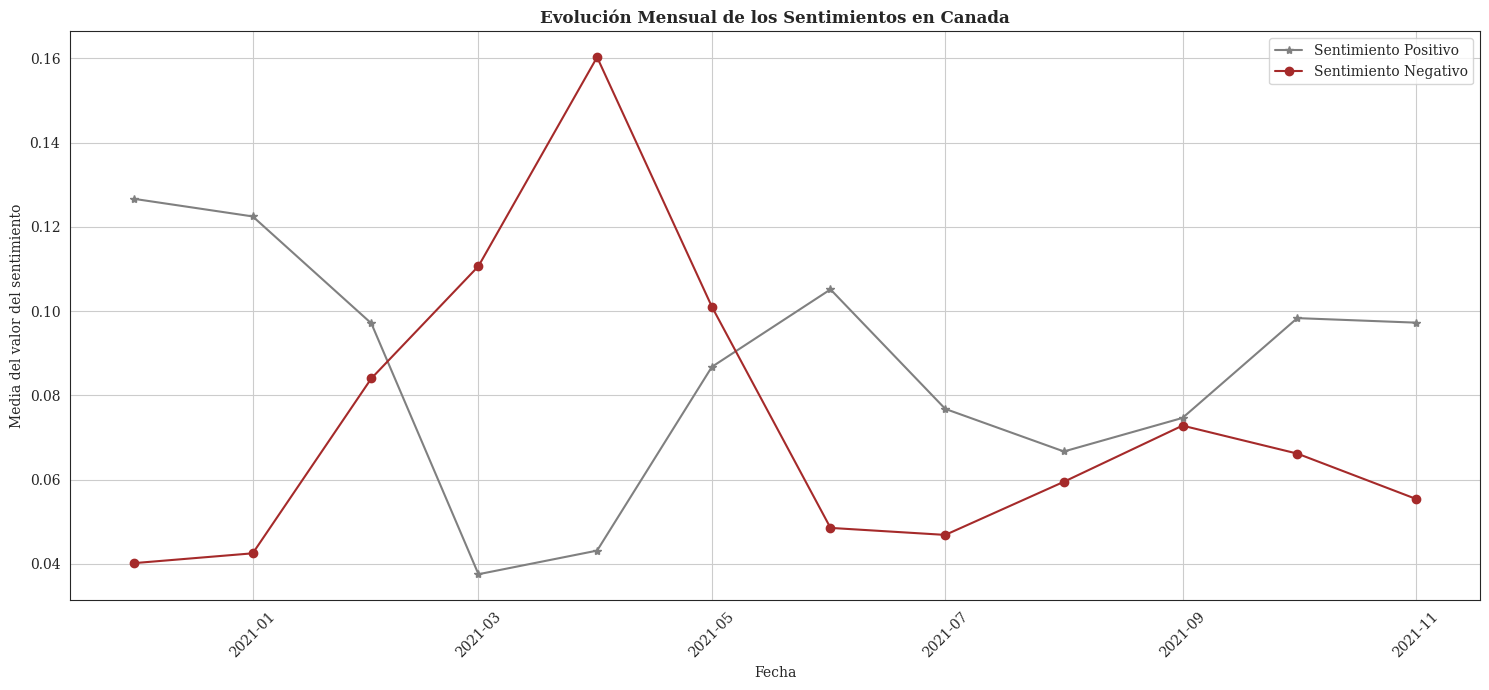

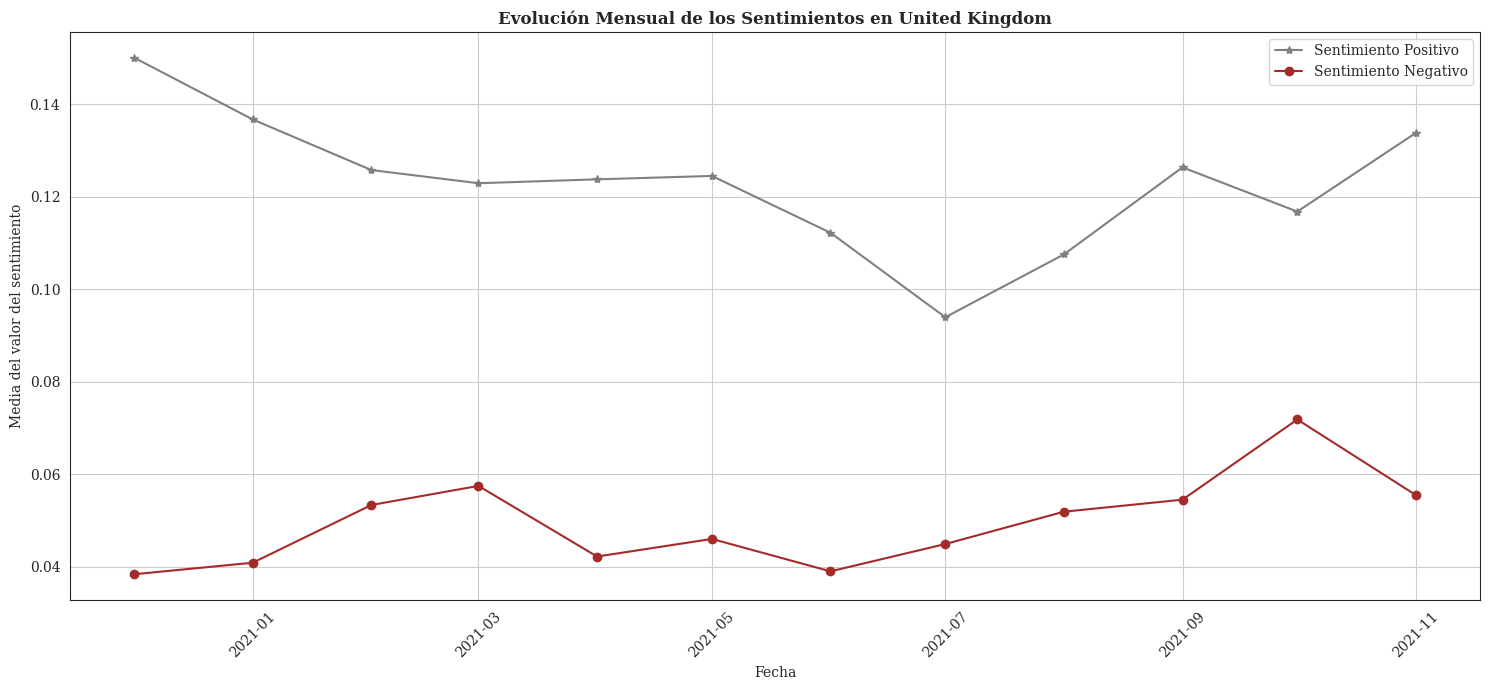

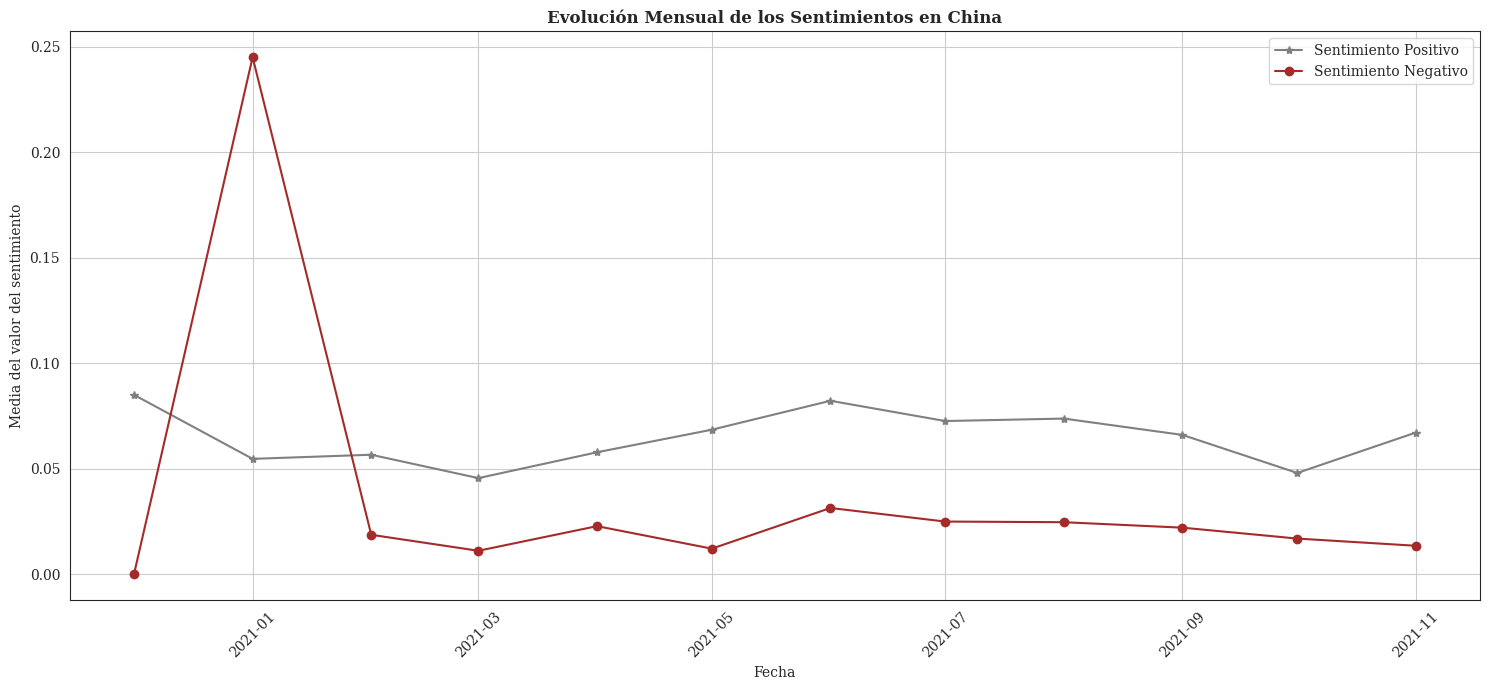

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupar por país y mes, calculando los sentimientos medios
monthly_sentiments_country = df.groupby([df['date'].dt.to_period('M'), 'country_from_city']).agg({
    'Positive Sentiment': 'mean',
    'Negative Sentiment': 'mean',
    'Neutral Sentiment': 'mean',
    'id': 'count'  # Contamos la cantidad de tweets
}).reset_index()

# Renombrar la columna de conteo de tweets
monthly_sentiments_country.rename(columns={'id': 'tweet_count'}, inplace=True)

# Obtener los 5 países con más tweets
top_countries = monthly_sentiments_country.groupby('country_from_city')['tweet_count'].sum().nlargest(6).index[1:6]

# Filtrar los datos para estos países
top_countries_sentiments = monthly_sentiments_country[monthly_sentiments_country['country_from_city'].isin(top_countries)]

# Convertir el periodo a timestamp para facilitar la visualización
top_countries_sentiments['date'] = top_countries_sentiments['date'].dt.to_timestamp()

# Crear los gráficos individualmente

# País 1
country1 = top_countries[0]
country1_data = top_countries_sentiments[top_countries_sentiments['country_from_city'] == country1]
plt.figure(figsize=(15, 7))
plt.plot(country1_data['date'], country1_data['Positive Sentiment'], marker='*', label='Sentimiento Positivo', color='gray')
plt.plot(country1_data['date'], country1_data['Negative Sentiment'], marker='o', label='Sentimiento Negativo', color='brown')
plt.title(f'Evolución Mensual de los Sentimientos en {country1}', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Media del valor del sentimiento')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# País 2
country2 = top_countries[1]
country2_data = top_countries_sentiments[top_countries_sentiments['country_from_city'] == country2]
plt.figure(figsize=(15, 7))
plt.plot(country2_data['date'], country2_data['Positive Sentiment'], marker='*', label='Sentimiento Positivo', color='gray')
plt.plot(country2_data['date'], country2_data['Negative Sentiment'], marker='o', label='Sentimiento Negativo', color='brown')
plt.title(f'Evolución Mensual de los Sentimientos en {country2}', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Media del valor del sentimiento')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# País 3
country3 = top_countries[2]
country3_data = top_countries_sentiments[top_countries_sentiments['country_from_city'] == country3]
plt.figure(figsize=(15, 7))
plt.plot(country3_data['date'], country3_data['Positive Sentiment'], marker='*', label='Sentimiento Positivo', color='gray')
plt.plot(country3_data['date'], country3_data['Negative Sentiment'], marker='o', label='Sentimiento Negativo', color='brown')
plt.title(f'Evolución Mensual de los Sentimientos en {country3}', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Media del valor del sentimiento')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# País 4
country4 = top_countries[3]
country4_data = top_countries_sentiments[top_countries_sentiments['country_from_city'] == country4]
plt.figure(figsize=(15, 7))
plt.plot(country4_data['date'], country4_data['Positive Sentiment'], marker='*', label='Sentimiento Positivo', color='gray')
plt.plot(country4_data['date'], country4_data['Negative Sentiment'], marker='o', label='Sentimiento Negativo', color='brown')
plt.title(f'Evolución Mensual de los Sentimientos en {country4}', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Media del valor del sentimiento')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# País 5
country5 = top_countries[4]
country5_data = top_countries_sentiments[top_countries_sentiments['country_from_city'] == country5]
plt.figure(figsize=(15, 7))
plt.plot(country5_data['date'], country5_data['Positive Sentiment'], marker='*', label='Sentimiento Positivo', color='gray')
plt.plot(country5_data['date'], country5_data['Negative Sentiment'], marker='o', label='Sentimiento Negativo', color='brown')
plt.title(f'Evolución Mensual de los Sentimientos en {country5}', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Media del valor del sentimiento')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-45-88be5242b41b>:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



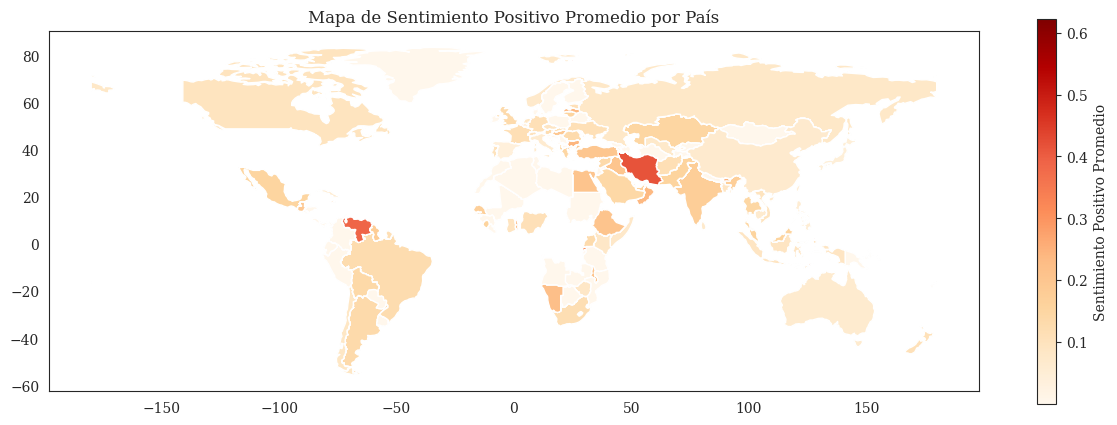

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar datos geoespaciales de países (puedes usar cualquier shapefile de países)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Unir con los datos de sentimiento promedio por país
choropleth_data = world.merge(monthly_sentiments_country, how='left', left_on='name', right_on='country_from_city')

# Crear el mapa de coropletas
choropleth_data.plot(column='Positive Sentiment', cmap='OrRd', legend=True,
                     legend_kwds={'label': "Sentimiento Positivo Promedio",'shrink': 0.5},
                     figsize=(15, 10))

plt.title('Mapa de Sentimiento Positivo Promedio por País')
plt.show()

<ipython-input-46-9d69b5fb689b>:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



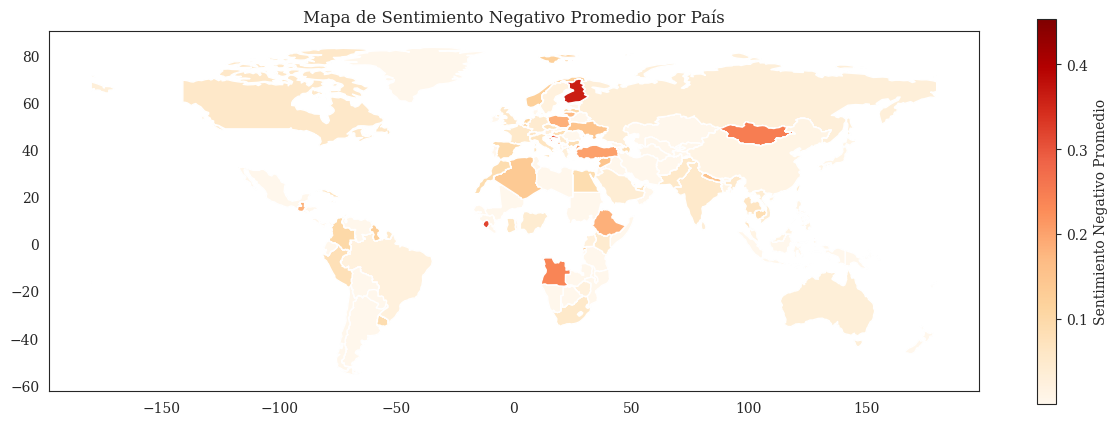

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar datos geoespaciales de países (puedes usar cualquier shapefile de países)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Unir con los datos de sentimiento promedio por país
choropleth_data = world.merge(monthly_sentiments_country, how='left', left_on='name', right_on='country_from_city')

# Crear el mapa de coropletas
choropleth_data.plot(column='Negative Sentiment', cmap='OrRd', legend=True,
                     legend_kwds={'label': "Sentimiento Negativo Promedio",'shrink': 0.5},
                     figsize=(15, 10))

plt.title('Mapa de Sentimiento Negativo Promedio por País')
plt.show()

<ipython-input-47-8c0cf75dd89d>:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



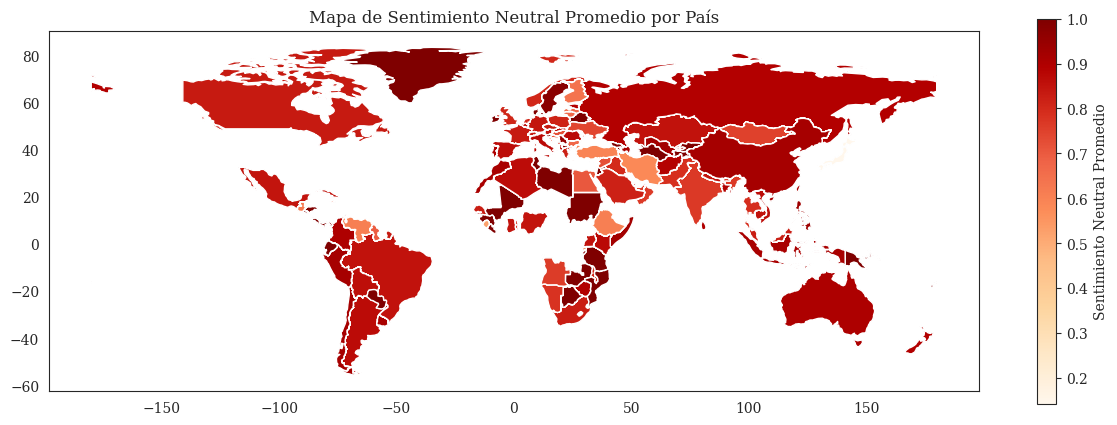

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar datos geoespaciales de países (puedes usar cualquier shapefile de países)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Unir con los datos de sentimiento promedio por país
choropleth_data = world.merge(monthly_sentiments_country, how='left', left_on='name', right_on='country_from_city')

# Crear el mapa de coropletas
choropleth_data.plot(column='Neutral Sentiment', cmap='OrRd', legend=True,
                     legend_kwds={'label': "Sentimiento Neutral Promedio",'shrink': 0.5},
                     figsize=(15, 10))

plt.title('Mapa de Sentimiento Neutral Promedio por País')
plt.show()

<ipython-input-48-c58815aadecf>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



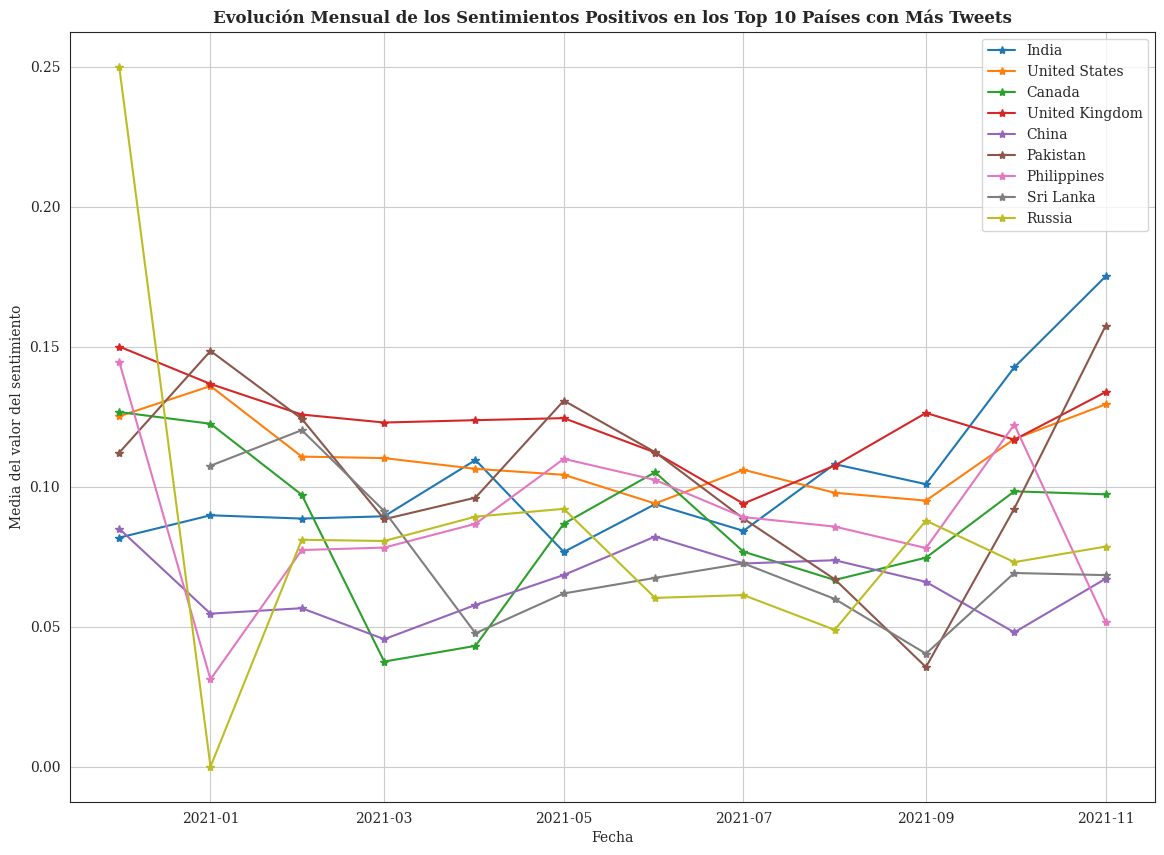

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que ya tenemos las columnas de sentimientos y la columna 'country_from_city' en el DataFrame

# Convertir la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupar por país y mes, calculando los sentimientos medios
monthly_sentiments_country = df.groupby([df['date'].dt.to_period('M'), 'country_from_city']).agg({
    'Positive Sentiment': 'mean',
    'Negative Sentiment': 'mean',
    'Neutral Sentiment': 'mean',
    'id': 'count'  # Contamos la cantidad de tweets
}).reset_index()

# Renombrar la columna de conteo de tweets
monthly_sentiments_country.rename(columns={'id': 'tweet_count'}, inplace=True)

# Obtener los 5 países con más tweets
top_countries = monthly_sentiments_country.groupby('country_from_city')['tweet_count'].sum().nlargest(10).index[1:10]

# Filtrar los datos para estos países
top_countries_sentiments = monthly_sentiments_country[monthly_sentiments_country['country_from_city'].isin(top_countries)]

# Convertir el periodo a timestamp para facilitar la visualización
top_countries_sentiments['date'] = top_countries_sentiments['date'].dt.to_timestamp()

# Visualización
plt.figure(figsize=(14, 10))

for country in top_countries:
    country_data = top_countries_sentiments[top_countries_sentiments['country_from_city'] == country]
    plt.plot(country_data['date'], country_data['Positive Sentiment'], marker='*', label=f'{country}')

plt.title('Evolución Mensual de los Sentimientos Positivos en los Top 10 Países con Más Tweets', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Media del valor del sentimiento')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-49-f5d9f7e642cf>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



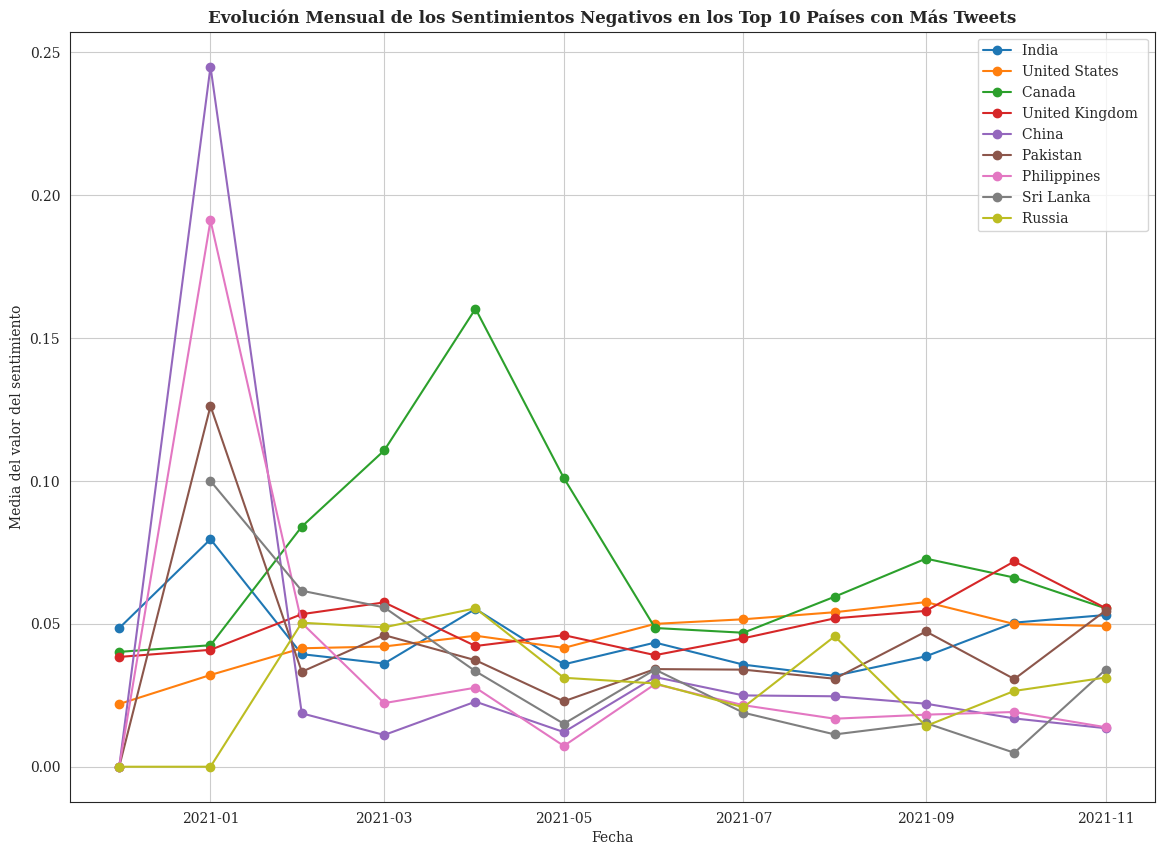

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que ya tenemos las columnas de sentimientos y la columna 'country_from_city' en el DataFrame

# Convertir la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'])

# Agrupar por país y mes, calculando los sentimientos medios
monthly_sentiments_country = df.groupby([df['date'].dt.to_period('M'), 'country_from_city']).agg({
    'Positive Sentiment': 'mean',
    'Negative Sentiment': 'mean',
    'Neutral Sentiment': 'mean',
    'id': 'count'  # Contamos la cantidad de tweets
}).reset_index()

# Renombrar la columna de conteo de tweets
monthly_sentiments_country.rename(columns={'id': 'tweet_count'}, inplace=True)

# Obtener los 5 países con más tweets
top_countries = monthly_sentiments_country.groupby('country_from_city')['tweet_count'].sum().nlargest(10).index[1:10]

# Filtrar los datos para estos países
top_countries_sentiments = monthly_sentiments_country[monthly_sentiments_country['country_from_city'].isin(top_countries)]

# Convertir el periodo a timestamp para facilitar la visualización
top_countries_sentiments['date'] = top_countries_sentiments['date'].dt.to_timestamp()

# Visualización
plt.figure(figsize=(14, 10))

for country in top_countries:
    country_data = top_countries_sentiments[top_countries_sentiments['country_from_city'] == country]
    plt.plot(country_data['date'], country_data['Negative Sentiment'], marker='o', label=f'{country} ')

plt.title('Evolución Mensual de los Sentimientos Negativos en los Top 10 Países con Más Tweets', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Media del valor del sentimiento')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Guardar el conjunto de datos actualizado
df.to_csv("dataset_analisis.csv", index=False)